# Project Description

This data analysis project uses machine learning and data balancing techniques to create a predictive model higher than the target AUC-ROC (0.93 versus goal of > 0.88).

# Project Overview

Interconnect provides landline communication, internet, and several complimentary services.
Clients select a monthly payment or yearly contracts.
Interconnect wants a model for predicting the churn of clientele.
If a user is forecast to leave, they will be offered promotional codes and special plan options.
Data Description

Data is valid as of February 1, 2020.
Four data files from different souces are provided.
contract.csv - contract information
personal.csv - the client's personal data
internet.csv - information about Interenet services
phone.csv - information about telephone services
The files are linked by the customerID column which contains a unique code assigned to each client.
The target feature is the EndDate column equal to No.
Project Goal

Create a classification model that predicts if a customer will leave soon based on the data files supplied.
AUC-ROC is the primary metric and needs to be at least 0.81, though greater than or equal to 0.88 is ideal.
Accuracy will also be reported.


In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date

#%pip install dexplot
import dexplot as dxp
import time
import matplotlib.ticker as ticker

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler as ss, OrdinalEncoder
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# Import data

In [2]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv') 
    personal = pd.read_csv('/datasets/final_provider/personal.csv') 
    internet = pd.read_csv('/datasets/final_provider/internet.csv') 
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
for file, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f'Shape of {file} is {df.shape}')

Shape of contract is (7043, 8)
Shape of personal is (7043, 5)
Shape of internet is (5517, 8)
Shape of phone is (6361, 2)


Dataframes Internet and phone could indicate missing values in the final merged dataframe. These values could be a missing product for the customer_id.

In [4]:
for file, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f' First few rows of the {file} dataframe \n {df.head()}')

 First few rows of the contract dataframe 
    customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
 First few rows of the personal dataframe 
    customerID  gender  SeniorCitizen Partner Dependen

Potential for creating more meaningful variables by combining begin and end dates: (1) number of active months, and (2) is_churned, and by creating a number of products variable. Encode dichotomous variables.

In [5]:
for file, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f'Pattern of missingness for {file} \n {df.isnull().sum()}')

Pattern of missingness for contract 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Pattern of missingness for personal 
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Pattern of missingness for internet 
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Pattern of missingness for phone 
 customerID       0
MultipleLines    0
dtype: int64


The individual dataframes do not have missing values

In [6]:
for file, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f' Type of variable in {file} \n {df.dtypes}')

 Type of variable in contract 
 customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object
 Type of variable in personal 
 customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object
 Type of variable in internet 
 customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object
 Type of variable in phone 
 customerID       object
MultipleLines    object
dtype: object


Change data types of: BeginDate, EndDate, TotalCharges

In [7]:
for file, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f'Sum of observation duplicates for the {file} dataframe is {df.duplicated().sum()}')

Sum of observation duplicates for the contract dataframe is 0
Sum of observation duplicates for the personal dataframe is 0
Sum of observation duplicates for the internet dataframe is 0
Sum of observation duplicates for the phone dataframe is 0


Observations

- The contract file has 7043 observations with no missing values, no duplicate rows.

- There are several datatypes will need to be addressed.

# Merging the dataframes 

In [8]:
df = personal.merge(contract, left_on=['customerID'], right_on=['customerID'], how='left')
df = df.merge(phone, left_on=['customerID'], right_on=['customerID'], how='left')
df = df.merge(internet, left_on=['customerID'], right_on=['customerID'], how='left')

In [9]:
df.shape

(7043, 20)

In [10]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No


# Data Cleaning

In [11]:
columns = []
for name in df.columns.values:
    name = re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)
df.columns = columns

In [12]:
df.isnull().sum()/df.shape[0] *100

ustomer_i_d           0.000000
ender                 0.000000
senior_citizen        0.000000
partner               0.000000
dependents            0.000000
begin_date            0.000000
end_date              0.000000
type                  0.000000
paperless_billing     0.000000
payment_method        0.000000
monthly_charges       0.000000
total_charges         0.000000
multiple_lines        9.683374
internet_service     21.666903
online_security      21.666903
online_backup        21.666903
device_protection    21.666903
tech_support         21.666903
streaming_t_v        21.666903
streaming_movies     21.666903
dtype: float64

In [13]:
df = df.rename(columns = {'ender':'gender', "ustomer_i_d": "customer_id", "streaming_t_v":"streaming_tv"})

Check the pattern of missingness of these variables.  It is assumed that these missing values exist because the customer did not subscribe to the service.

In [14]:
df.duplicated().sum()

0

## For the missing data, we assume that the customer has not subscribed to this service

In [15]:
for col in ["online_security","online_backup","device_protection","tech_support",
            "streaming_tv","streaming_movies", "multiple_lines",
           "partner","dependents"]:
    df[col] = df[col].fillna("No").apply(lambda x: 0 if x == 'No' else 1)

In [16]:
df["internet_service"] = df["internet_service"].fillna("No Service")

In [17]:
df['total_charges'] = df['total_charges'].replace(" ", np.nan).astype(np.float64)

# Feature Engineering

## Create the target: Churn

In [18]:
df['end_date'].max(),df['end_date'].min()

('No', '2019-10-01 00:00:00')

In [19]:
df['churn'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)
df.churn.value_counts()/df.shape[0]

0    0.73463
1    0.26537
Name: churn, dtype: float64

## For the date variables, change type and create new variable:

days_of_service

day

month

year


In [20]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

In [21]:
df['begin_date'].max(), df['begin_date'].min()

(Timestamp('2020-02-01 00:00:00'), Timestamp('2013-10-01 00:00:00'))

In [22]:
final_date = pd.to_datetime('2020-02-02') 
#final_date_temp = pd.to_datetime('2020-02-01') # check
df['days_of_service'] = (final_date - df['begin_date']).dt.days

In [23]:
df['days_of_service'].min(), df['days_of_service'].max()

(1, 2315)

In [24]:
df['days_of_service'] = df['days_of_service'].astype(np.float64)

In [25]:
df['year'] = df['begin_date'].dt.year
df['month'] = df['begin_date'].dt.month
df['day_of_week'] = df['begin_date'].dt.dayofweek

In [26]:
df["end_date"] = df["end_date"].replace("No", 0)

In [27]:
df["end_date"].value_counts()

0                      5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [28]:
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d') #, errors='coerce')

## Create new variable: Services

In [29]:
services = ['paperless_billing', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df['services'] = df[services].sum(axis=1).astype('int')

/var/folders/gk/hvqbhchj1fqfp9s9tq_k1rfr0000gp/T/ipykernel_14980/2885660360.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['services'] = df[services].sum(axis=1).astype('int')


## Change type

In [30]:
df["total_charges"] = pd.to_numeric(df["total_charges"], errors="coerce").fillna(0.0)

## Check for missing values

In [31]:
df.isnull().sum()/df.shape[0] *100

customer_id          0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
multiple_lines       0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
churn                0.0
days_of_service      0.0
year                 0.0
month                0.0
day_of_week          0.0
services             0.0
dtype: float64

# EDA

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


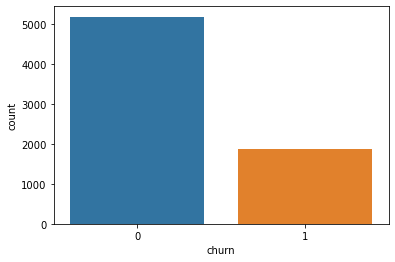

In [32]:
sns.countplot(df["churn"]);

In [33]:
df_no_id = df.drop('customer_id', axis=1)  

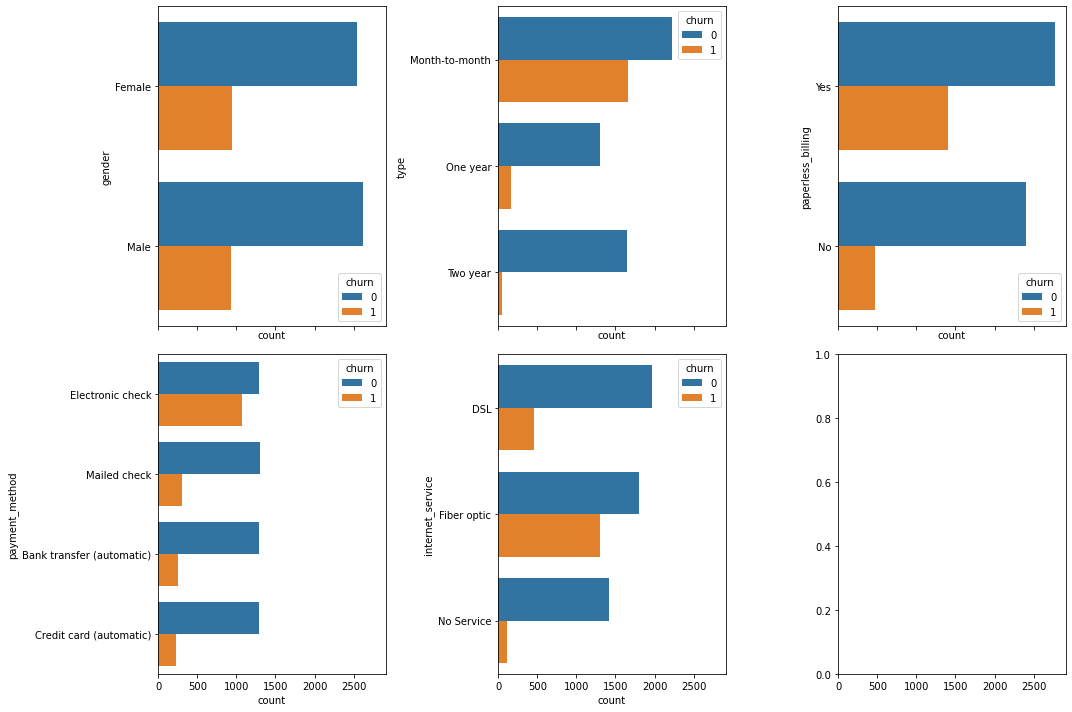

In [34]:
#sns.set(font_scale=1)
fig, axes =plt.subplots(2,3, figsize=(15,10), sharex=True)
axes = axes.flatten()
object_bol = df_no_id.dtypes == 'object'
for ax, catplot in zip(axes, df_no_id.dtypes[object_bol].index):
    sns.countplot(y=catplot, data=df, ax=ax,   hue = "churn")
plt.tight_layout()  
plt.show()

Observations

- Churning seems associated with month-to-month type of contract, paperless billing, electronic checks type of payment and fiber optic internet service.

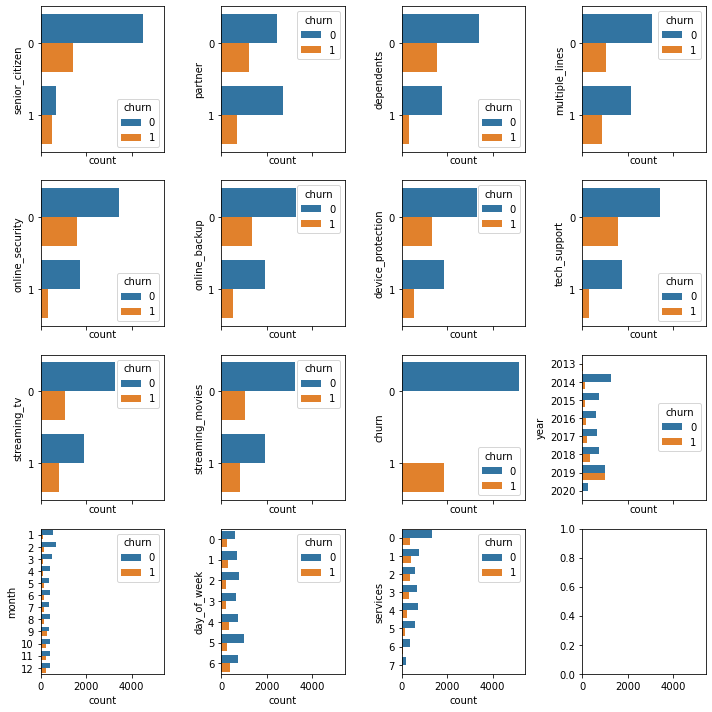

In [35]:
fig, axes =plt.subplots(4,4, figsize=(10,10), sharex=True)
axes = axes.flatten()
object_bol = df.dtypes == 'int'
for ax, catplot in zip(axes, df.dtypes[object_bol].index):
    sns.countplot(y=catplot, data=df, ax=ax, hue = "churn")
plt.tight_layout()  
plt.show()

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/dexplot/_common_plot.py:156: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  self.data[name].cat.remove_unused_categories(inplace=True)


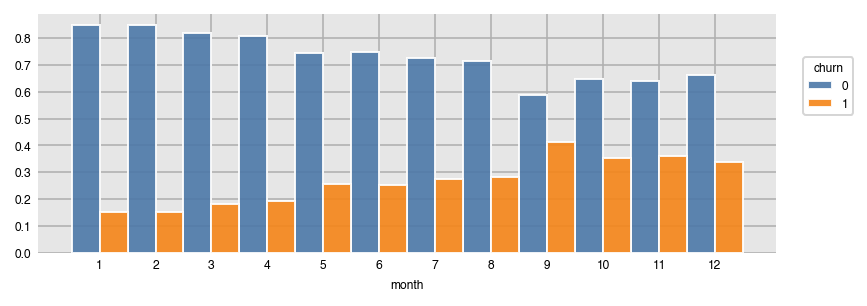

In [36]:
dxp.count("month", data=df, split='churn', normalize = "month", size=1)

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/dexplot/_common_plot.py:156: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  self.data[name].cat.remove_unused_categories(inplace=True)


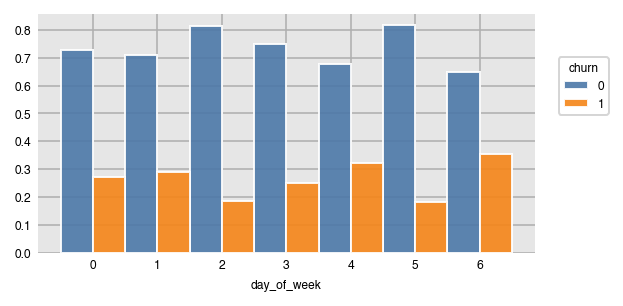

In [37]:
dxp.count("day_of_week", data=df, split='churn', normalize = "day_of_week", size=1)

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/dexplot/_common_plot.py:156: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  self.data[name].cat.remove_unused_categories(inplace=True)


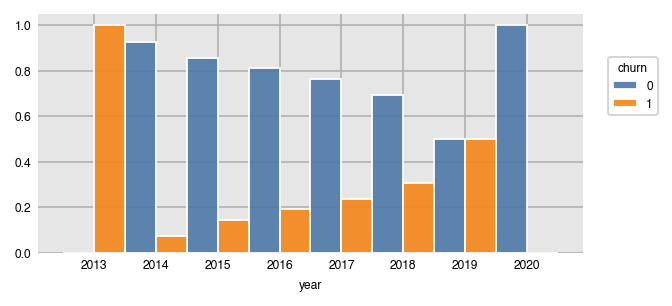

In [38]:
dxp.count("year", data=df, split='churn', normalize = "year", size=1)

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/dexplot/_common_plot.py:156: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  self.data[name].cat.remove_unused_categories(inplace=True)


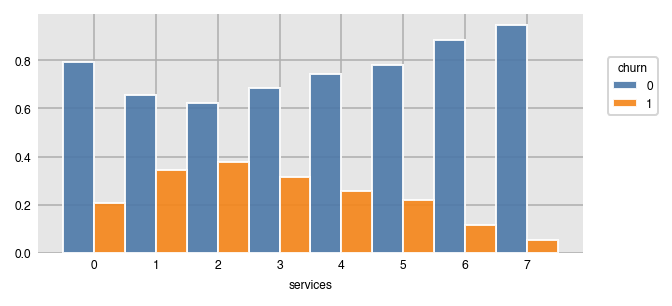

In [39]:
dxp.count("services", data=df, split='churn', normalize = "services", size=1)

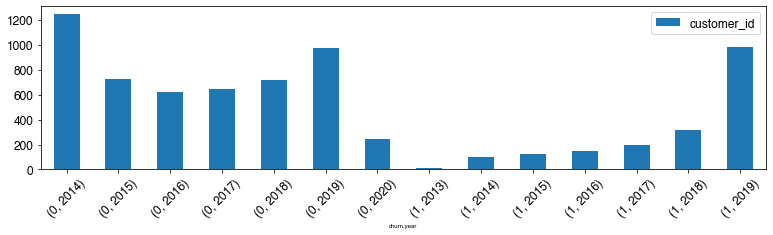

In [40]:
df.groupby(["churn",  "year"], sort = True).agg({'customer_id': 'count'}).plot(
    kind='bar', figsize=(13, 3), fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12);

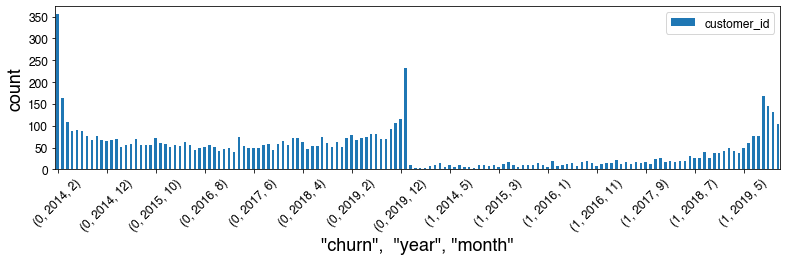

In [41]:
df.groupby(["churn",  "year", "month"], sort = True).agg({'customer_id': 'count'}).plot(
    kind='bar',  figsize=(13, 3), fontsize=12)
plt.xticks(np.arange(0, 150, step=10))
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.xlabel('"churn",  "year", "month"', fontsize=18)
plt.ylabel('count', fontsize=18);

Observations

- Churning seems associated with no online sercurity, no backup support, no device protection and no tech support.
- The last months of the year seem most associated with churning
- Those customers with 1 to 3 services are most associated with churning
- Churning has been increasing every year and reaches its peak in 2019, but then drops 
- Midweek (Wednesday and Thursday) and Saturdays are most associated with churning.
- In short, the total number of customers that churned starts to increase in September 2017 and increases exponentially until October 2019 and then drops significantly.

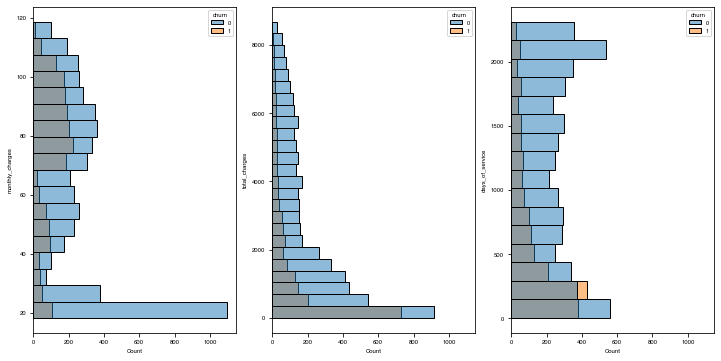

In [42]:
fig, axes =plt.subplots(1,3, figsize=(10,5), sharex=True)
axes = axes.flatten()
object_bol = df.dtypes == 'float'

for ax, floatplot in zip(axes, df.dtypes[object_bol].index):
    sns.histplot(y=floatplot, data=df, ax=ax, hue = "churn")

plt.tight_layout()  
plt.show()

In [43]:
active = df[df['churn'] == 0]
churned = df[df['churn'] == 1]

In [44]:
df.groupby('churn')['monthly_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
1,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


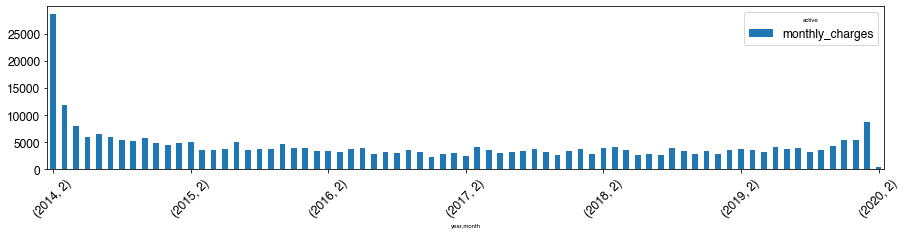

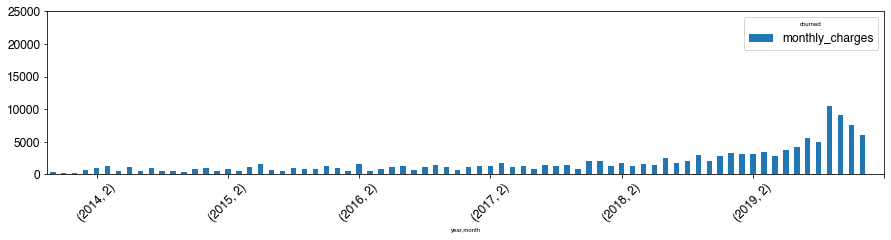

In [45]:
dfa = active.groupby([ "year", "month"], sort = True).agg({'monthly_charges': 'sum'})
dfa.plot(kind='bar', fontsize=12, figsize=(15, 3))
plt.xticks(rotation=45)
plt.yticks(np.arange(0,30000, 5000)),
plt.xticks(np.arange(0, 80, step=12))
plt.legend(title='active', fontsize=12)
dfb = churned.groupby([ "year", "month"], sort = True).agg({'monthly_charges': 'sum'})
dfb.plot(kind='bar', figsize=(15, 3), fontsize=12)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,30000, 5000)),
plt.xticks(np.arange(4, 80, step=12))
plt.legend(title='churned',fontsize=12);

In [46]:
df.groupby('churn')['total_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,5174.0,2549.911442,2329.954215,0.00,572.9,1679.525,4262.85,8672.45
1,1869.0,1531.796094,1890.822994,18.85,134.5,703.550,2331.30,8684.80


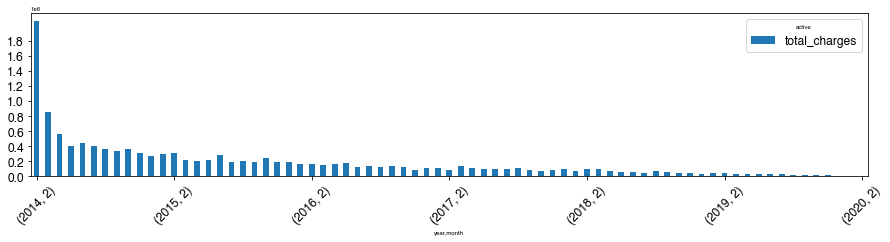

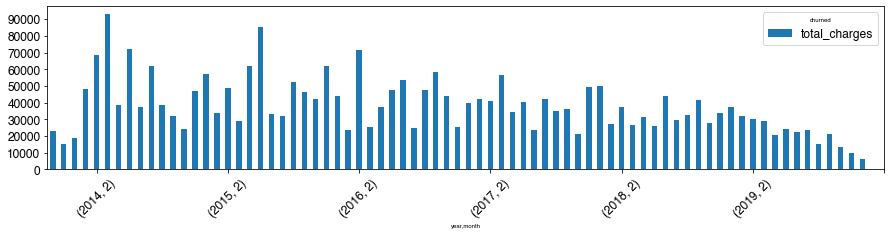

In [47]:
dfa = active.groupby([ "year", "month"], sort = True).agg({'total_charges': 'sum'})
dfa.plot(kind='bar', fontsize=12, figsize=(15, 3))
plt.xticks(rotation=45)
plt.yticks(np.arange(0,2000000, 200000)),
plt.xticks(np.arange(0, 80, step=12))
plt.legend(title='active', fontsize=12)
dfb = churned.groupby([ "year", "month"], sort = True).agg({'total_charges': 'sum'})
dfb.plot(kind='bar', figsize=(15, 3), fontsize=12)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,100000, 10000)),
plt.xticks(np.arange(4, 80, step=12))
plt.legend(title='churned',fontsize=12);

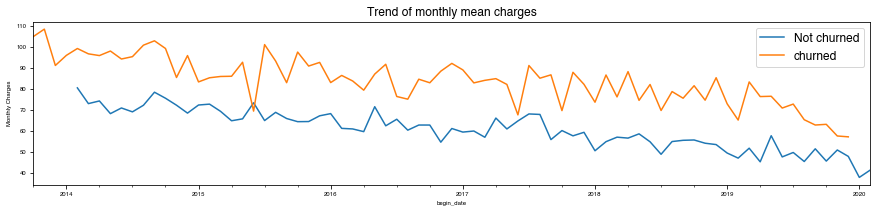

In [48]:
fig, ax = plt.subplots(figsize=(15, 3))
for target in [0, 1]:
    df[df['churn'] == target].groupby('begin_date')['monthly_charges'].mean().plot(label=target)
plt.legend(labels=['Not churned', 'churned'], fontsize = 12)
plt.xlabel('begin_date')
plt.ylabel('Monthly Charges')
plt.title('Trend of monthly mean charges', fontsize = 12)
plt.show()

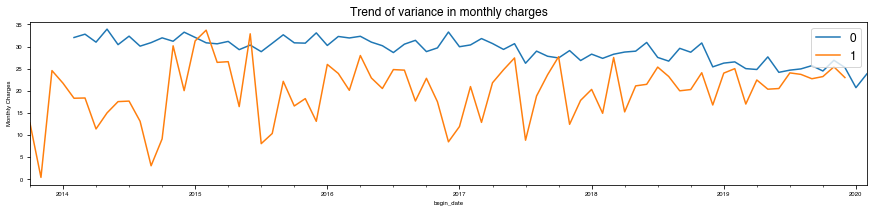

In [49]:
fig, ax = plt.subplots(figsize=(15, 3))
for target in [0, 1]:
    df[df['churn'] == target].groupby('begin_date')['monthly_charges'].std().plot(label=target)
plt.legend(labels=['Not churned', 'Churned'])
plt.xlabel('begin_date')
plt.ylabel('Monthly Charges')
plt.legend(loc='upper right', fontsize = 12)
plt.title('Trend of variance in monthly charges', fontsize = 12)
plt.show()

In [50]:
df.groupby('churn')['days_of_service'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,5174.0,1145.447236,733.897937,1.0,458.0,1158.0,1858.0,2192.0
1,1869.0,625.455324,595.910567,63.0,154.0,366.0,946.0,2315.0


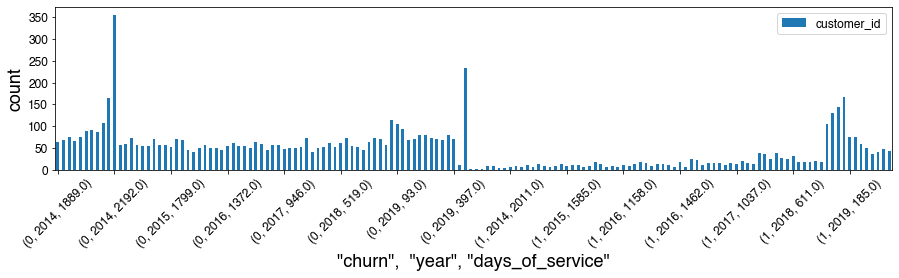

In [51]:
df.groupby(["churn", "year",  "days_of_service"], sort = True).agg({'customer_id': 'count'}).plot(
    kind='bar', figsize=(15, 3), fontsize=12)
plt.xticks(np.arange(0, 150, step=10))
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.xlabel('"churn",  "year", "days_of_service"', fontsize=18)
plt.ylabel('count', fontsize=18);

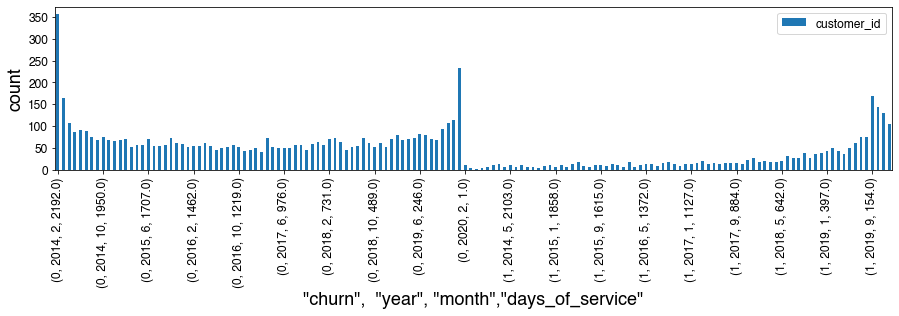

In [52]:
df.groupby(["churn", "year", "month", "days_of_service"], sort = True).agg({'customer_id': 'count'}).plot(
    kind='bar', figsize=(15, 3), fontsize=12)
plt.xticks(np.arange(0, 150, step=8))
plt.xticks(rotation=90)
plt.legend(fontsize=12)
plt.xlabel('"churn",  "year", "month","days_of_service"', fontsize=18)
plt.ylabel('count', fontsize=18);

Observations

- The mean monthly charges of those who churned is around 18% higher than those customers who are still active.  This trend is evident in the line chart above.  Only in mid 2015 and 2017 these mean become equal.  This line seems a bit smoother for those who are still active indicating less variance in monthly charges.  In fact, the second line chart tackles this head-on and shows that in fact the monthly charges of those who churned are volatile.  
- The bulk of those who churned seems to increase as monthly charges increase.  In may 2019, churning increases gradually to reach a peak in September.
- The mean total charges for those who churned is 40\% less that those who are still active.  Over time, the total charges of active accounts is decreasing.  However, the total charges of those who churned seem t be more volatile
- Churning seems associated with overall lower days of service.  The mean days_of_service for those who churned is half that of those who are still active.  In mid 2018, there seems to be a spike in the days_of_service of those who churned.  Although this surge is attenuated, it does not go back to its pre 2018 levels.  In fact, this surge peaked in January 2019, but has since decreased.

# Preprocessing

In [53]:
df = df.drop(['customer_id', 
              'end_date', 'begin_date'], axis=1) 

In [55]:
list_obj = (df.dtypes == 'object')
object_cols = list(list_obj[list_obj].index)

In [56]:
df = pd.get_dummies(df, drop_first=True, columns = object_cols)

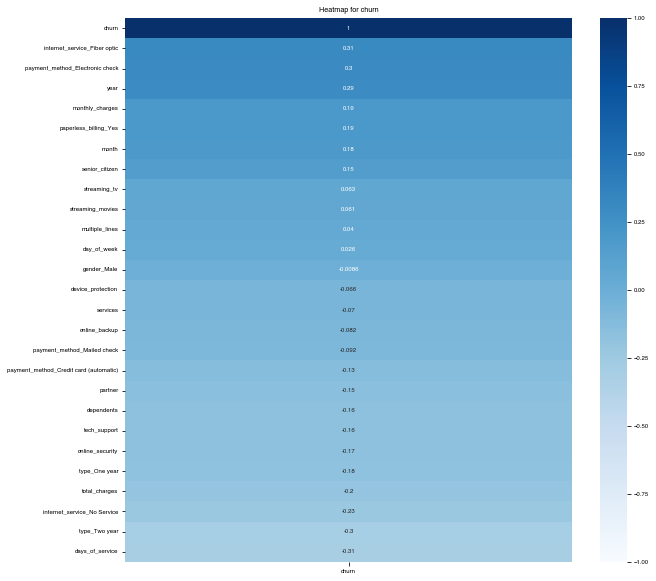

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr()[["churn"]].sort_values(by="churn", ascending=False), vmin=-1, vmax=1,  annot=True, cmap='Blues')
ax.set(title="Heatmap for " + "churn");

In [57]:
corr_df = df.corr()
corr_df.iloc[corr_df['churn'].abs().argsort()]["churn"]

gender_Male                              -0.008612
day_of_week                               0.026492
multiple_lines                            0.040102
streaming_movies                          0.061382
streaming_tv                              0.063228
device_protection                        -0.066160
services                                 -0.069533
online_backup                            -0.082255
payment_method_Mailed check              -0.091683
payment_method_Credit card (automatic)   -0.134302
partner                                  -0.150448
senior_citizen                            0.150889
dependents                               -0.164221
tech_support                             -0.164674
online_security                          -0.171226
type_One year                            -0.177820
month                                     0.181417
paperless_billing_Yes                     0.191825
monthly_charges                           0.193356
total_charges                  

Observations
  
- For a first glance, the following variables seems important and correlated with the target:

(1) days_of_service, 

(2) internet_service_Fiber_optic,

(3) type_Two_year, 

(4) payment_method_Electronic check 

(5) year, 

(6) internet_service_No_Service, 

(7) total_charges, 

(8) monthly_charges, 

(9) paperless_billing_Yes, 

(10) month 

In [64]:
# create feature and target variables 
target = df['churn']
features = df.drop(['churn'], axis=1)

In [65]:
# divide data with OHE into 3 groups using 3:1:1 (60%, 20%, 20%) ratio
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.4, random_state = 12345)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, shuffle = False, random_state=12345)
print('Train target and features and percentage\n', y_train.shape, X_train.shape,
      'pct', (len(y_train)/len(df)))
print('Valid target and features and percentage\n', y_valid.shape, X_valid.shape,
      'pct', (len(y_valid)/len(df)))
print('Test target and features and percentage\n', y_test.shape, X_test.shape,
      'pct', (len(y_test)/len(df)))

Train target and features and percentage
 (4225,) (4225, 26) pct 0.5998864120403238
Valid target and features and percentage
 (1409,) (1409, 26) pct 0.20005679397983814
Test target and features and percentage
 (1409,) (1409, 26) pct 0.20005679397983814


In [66]:
sc = ss()
X_train_scaled = sc.fit_transform(X_train)
X_valid_scaled = sc.transform(X_valid)
X_test_scaled = sc.transform(X_test)

In [67]:
X_train = pd.DataFrame(data=X_train_scaled,
                        index=X_train.index,    
                        columns=X_train.columns) 

In [68]:
X_valid = pd.DataFrame(data=X_valid_scaled,
                        index=X_valid.index,    
                        columns=X_valid.columns) 

In [69]:
X_test = pd.DataFrame(data=X_test_scaled,
                        index=X_test.index,    
                        columns=X_test.columns) 

# Building the models

In [70]:
def build_model(model, train_X, train_y, valid_X, valid_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict_proba(train_X)[:, 1]
        best_score = roc_auc_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'cat':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict_proba(valid_X)[:, 1]
    best_score = roc_auc_score(valid_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

In [71]:
def roc_auc_scorer(y_true, y_pred):
    """
    Use the customer scorer for roc_auc_score
    inside GridSearch
    """
    return roc_auc_score(y_true, y_pred)

In [72]:
def display_classification_report(y_valid, y_pred):
    display(pd.DataFrame(classification_report(y_valid, y_pred, output_dict=True)).T)

In [73]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, ax = plt.subplots(figsize=(10, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        
        # ROC
        fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
        roc_auc = roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # ROC
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        
        eval_stats[type]['Accuracy'] = accuracy_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Rhea/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.731015,1.000000,0.844608,1030.000000
1,0.000000,0.000000,0.000000,379.000000
accuracy,0.731015,0.731015,0.731015,0.731015
macro avg,0.365507,0.500000,0.422304,1409.000000
weighted avg,0.534383,0.731015,0.617421,1409.000000


          train  test
Accuracy   0.74  0.73
ROC AUC    0.50  0.50


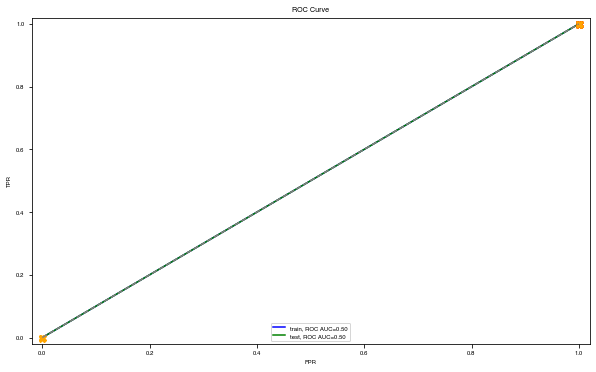

In [74]:
dc = DummyClassifier()
best_dc_model, best_dc_auc, best_dc_time  = build_model(dc, X_train, y_train, 
                                                        X_valid, y_valid,
                                                        hyperparameters={}, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=2, model_str='dummy')
y_pred = dc.predict(X_valid)
display_classification_report(y_valid, y_pred)

result = evaluate_model(dc, X_train, y_train, X_valid, y_valid);

The confusion matrix is [[763 267]
 [ 81 298]]


,precision,recall,f1-score,support
0,0.904028,0.740777,0.814301,1030.000000
1,0.527434,0.786280,0.631356,379.000000
accuracy,0.753016,0.753016,0.753016,0.753016
macro avg,0.715731,0.763528,0.722828,1409.000000
weighted avg,0.802730,0.753016,0.765091,1409.000000


          train  test
Accuracy   0.76  0.75
ROC AUC    0.85  0.85


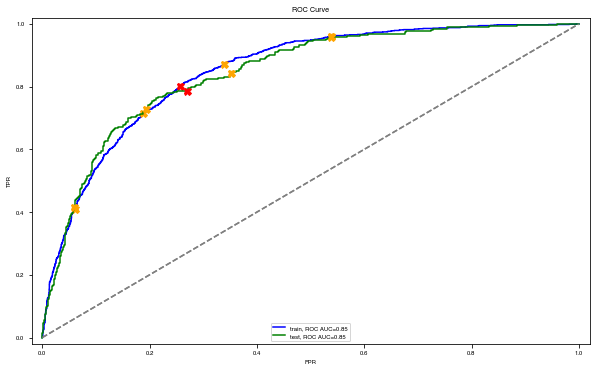

In [75]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
best_lr_model, best_lr_auc, best_lr_time = build_model(lr, X_train, y_train, 
                                                        X_valid, y_valid,
                                                        hyperparameters={'C' : [.001, .01, .1, 1, 10]}, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=5)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)


print("The confusion matrix is", confusion_matrix(y_valid, y_pred))

display_classification_report(y_valid, y_pred)
result = evaluate_model(lr, X_train, y_train, X_valid, y_valid);

The confusion matrix is [[993  37]
 [162 217]]


,precision,recall,f1-score,support
0,0.859740,0.964078,0.908924,1030.000000
1,0.854331,0.572559,0.685624,379.000000
accuracy,0.858765,0.858765,0.858765,0.858765
macro avg,0.857035,0.768319,0.797274,1409.000000
weighted avg,0.858285,0.858765,0.848860,1409.000000


          train  test
Accuracy    1.0  0.86
ROC AUC     1.0  0.89


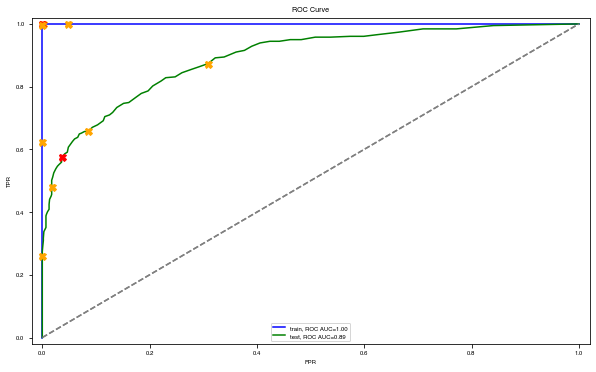

In [76]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
best_rf_model, best_rf_auc, best_rf_time  = build_model(rf, X_train, y_train, 
                                                        X_valid, y_valid,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)

print("The confusion matrix is", confusion_matrix(y_valid, y_pred))

display_classification_report(y_valid, y_pred)
result = evaluate_model(rf, X_train, y_train, X_valid, y_valid);

0:	learn: 0.5791299	total: 95ms	remaining: 9.4s
1:	learn: 0.5207276	total: 100ms	remaining: 4.91s
2:	learn: 0.4713883	total: 103ms	remaining: 3.32s
3:	learn: 0.4336783	total: 105ms	remaining: 2.52s
4:	learn: 0.4131625	total: 107ms	remaining: 2.03s
5:	learn: 0.4030921	total: 109ms	remaining: 1.7s
6:	learn: 0.3896614	total: 110ms	remaining: 1.47s
7:	learn: 0.3822292	total: 112ms	remaining: 1.29s
8:	learn: 0.3756249	total: 114ms	remaining: 1.15s
9:	learn: 0.3694965	total: 115ms	remaining: 1.04s
10:	learn: 0.3638205	total: 117ms	remaining: 945ms
11:	learn: 0.3585078	total: 118ms	remaining: 867ms
12:	learn: 0.3524340	total: 120ms	remaining: 802ms
13:	learn: 0.3493282	total: 121ms	remaining: 744ms
14:	learn: 0.3469076	total: 123ms	remaining: 696ms
15:	learn: 0.3410394	total: 124ms	remaining: 652ms
16:	learn: 0.3369658	total: 126ms	remaining: 614ms
17:	learn: 0.3317469	total: 127ms	remaining: 580ms
18:	learn: 0.3303570	total: 129ms	remaining: 549ms
19:	learn: 0.3270364	total: 130ms	remaining:

0:	learn: 0.5805381	total: 2.02ms	remaining: 200ms
1:	learn: 0.5243898	total: 4.54ms	remaining: 222ms
2:	learn: 0.4702008	total: 7.71ms	remaining: 249ms
3:	learn: 0.4456770	total: 9.9ms	remaining: 238ms
4:	learn: 0.4248024	total: 12ms	remaining: 227ms
5:	learn: 0.4129254	total: 14.1ms	remaining: 220ms
6:	learn: 0.4001928	total: 16.9ms	remaining: 224ms
7:	learn: 0.3920261	total: 19ms	remaining: 218ms
8:	learn: 0.3821001	total: 22.5ms	remaining: 228ms
9:	learn: 0.3754033	total: 24.7ms	remaining: 222ms
10:	learn: 0.3722210	total: 26.7ms	remaining: 216ms
11:	learn: 0.3651385	total: 30.3ms	remaining: 222ms
12:	learn: 0.3595822	total: 32.3ms	remaining: 216ms
13:	learn: 0.3565160	total: 34.3ms	remaining: 211ms
14:	learn: 0.3527029	total: 36.9ms	remaining: 209ms
15:	learn: 0.3482731	total: 39.5ms	remaining: 207ms
16:	learn: 0.3454892	total: 42.2ms	remaining: 206ms
17:	learn: 0.3387587	total: 44.5ms	remaining: 203ms
18:	learn: 0.3337333	total: 47.1ms	remaining: 201ms
19:	learn: 0.3307931	total:

98:	learn: 0.1700198	total: 162ms	remaining: 1.64ms
99:	learn: 0.1689746	total: 165ms	remaining: 0us
0:	learn: 0.5747670	total: 1.87ms	remaining: 186ms
1:	learn: 0.5133801	total: 3.71ms	remaining: 182ms
2:	learn: 0.4607389	total: 5.63ms	remaining: 182ms
3:	learn: 0.4328943	total: 7.96ms	remaining: 191ms
4:	learn: 0.4112102	total: 10.3ms	remaining: 196ms
5:	learn: 0.3975467	total: 12.6ms	remaining: 198ms
6:	learn: 0.3870404	total: 14.8ms	remaining: 196ms
7:	learn: 0.3799706	total: 16.9ms	remaining: 194ms
8:	learn: 0.3736175	total: 19ms	remaining: 193ms
9:	learn: 0.3656449	total: 21.2ms	remaining: 191ms
10:	learn: 0.3619094	total: 23ms	remaining: 186ms
11:	learn: 0.3484041	total: 24.5ms	remaining: 180ms
12:	learn: 0.3449343	total: 26.1ms	remaining: 175ms
13:	learn: 0.3433117	total: 27.7ms	remaining: 170ms
14:	learn: 0.3404251	total: 29.7ms	remaining: 168ms
15:	learn: 0.3374624	total: 31.7ms	remaining: 167ms
16:	learn: 0.3343196	total: 33.5ms	remaining: 163ms
17:	learn: 0.3292121	total: 3

109:	learn: 0.1572496	total: 183ms	remaining: 150ms
110:	learn: 0.1559036	total: 185ms	remaining: 148ms
111:	learn: 0.1547966	total: 188ms	remaining: 147ms
112:	learn: 0.1537014	total: 190ms	remaining: 146ms
113:	learn: 0.1529039	total: 192ms	remaining: 145ms
114:	learn: 0.1519122	total: 194ms	remaining: 144ms
115:	learn: 0.1508054	total: 196ms	remaining: 142ms
116:	learn: 0.1495245	total: 199ms	remaining: 141ms
117:	learn: 0.1487514	total: 201ms	remaining: 140ms
118:	learn: 0.1474187	total: 203ms	remaining: 138ms
119:	learn: 0.1458665	total: 205ms	remaining: 137ms
120:	learn: 0.1450096	total: 207ms	remaining: 135ms
121:	learn: 0.1439919	total: 210ms	remaining: 134ms
122:	learn: 0.1427095	total: 211ms	remaining: 132ms
123:	learn: 0.1418878	total: 213ms	remaining: 131ms
124:	learn: 0.1415615	total: 215ms	remaining: 129ms
125:	learn: 0.1409201	total: 218ms	remaining: 128ms
126:	learn: 0.1398892	total: 220ms	remaining: 126ms
127:	learn: 0.1388292	total: 222ms	remaining: 125ms
128:	learn: 

112:	learn: 0.1522855	total: 359ms	remaining: 277ms
113:	learn: 0.1505321	total: 362ms	remaining: 273ms
114:	learn: 0.1495869	total: 369ms	remaining: 273ms
115:	learn: 0.1487361	total: 375ms	remaining: 272ms
116:	learn: 0.1478307	total: 377ms	remaining: 268ms
117:	learn: 0.1467778	total: 385ms	remaining: 267ms
118:	learn: 0.1457296	total: 389ms	remaining: 264ms
119:	learn: 0.1445905	total: 391ms	remaining: 261ms
120:	learn: 0.1437378	total: 393ms	remaining: 257ms
121:	learn: 0.1430214	total: 399ms	remaining: 255ms
122:	learn: 0.1424251	total: 405ms	remaining: 253ms
123:	learn: 0.1415970	total: 407ms	remaining: 249ms
124:	learn: 0.1406723	total: 413ms	remaining: 248ms
125:	learn: 0.1402257	total: 421ms	remaining: 247ms
126:	learn: 0.1389210	total: 423ms	remaining: 243ms
127:	learn: 0.1382096	total: 431ms	remaining: 242ms
128:	learn: 0.1368003	total: 434ms	remaining: 239ms
129:	learn: 0.1353822	total: 437ms	remaining: 235ms
130:	learn: 0.1347059	total: 439ms	remaining: 231ms
131:	learn: 

107:	learn: 0.1583075	total: 390ms	remaining: 332ms
108:	learn: 0.1571266	total: 395ms	remaining: 330ms
109:	learn: 0.1559498	total: 399ms	remaining: 326ms
110:	learn: 0.1544952	total: 402ms	remaining: 322ms
111:	learn: 0.1540554	total: 408ms	remaining: 321ms
112:	learn: 0.1528704	total: 416ms	remaining: 321ms
113:	learn: 0.1524991	total: 420ms	remaining: 317ms
114:	learn: 0.1519065	total: 424ms	remaining: 314ms
115:	learn: 0.1507640	total: 430ms	remaining: 312ms
116:	learn: 0.1496477	total: 434ms	remaining: 308ms
117:	learn: 0.1479729	total: 437ms	remaining: 304ms
118:	learn: 0.1470677	total: 440ms	remaining: 299ms
119:	learn: 0.1465198	total: 442ms	remaining: 295ms
120:	learn: 0.1457096	total: 445ms	remaining: 291ms
121:	learn: 0.1449419	total: 448ms	remaining: 287ms
122:	learn: 0.1438043	total: 450ms	remaining: 282ms
123:	learn: 0.1429255	total: 452ms	remaining: 277ms
124:	learn: 0.1415441	total: 454ms	remaining: 273ms
125:	learn: 0.1403889	total: 458ms	remaining: 269ms
126:	learn: 

86:	learn: 0.1865131	total: 239ms	remaining: 310ms
87:	learn: 0.1854989	total: 241ms	remaining: 307ms
88:	learn: 0.1836471	total: 244ms	remaining: 304ms
89:	learn: 0.1819919	total: 246ms	remaining: 301ms
90:	learn: 0.1803609	total: 249ms	remaining: 298ms
91:	learn: 0.1790016	total: 251ms	remaining: 295ms
92:	learn: 0.1774405	total: 254ms	remaining: 292ms
93:	learn: 0.1759668	total: 256ms	remaining: 288ms
94:	learn: 0.1745586	total: 258ms	remaining: 285ms
95:	learn: 0.1729158	total: 260ms	remaining: 282ms
96:	learn: 0.1720790	total: 265ms	remaining: 281ms
97:	learn: 0.1707259	total: 268ms	remaining: 279ms
98:	learn: 0.1700198	total: 275ms	remaining: 280ms
99:	learn: 0.1689746	total: 281ms	remaining: 281ms
100:	learn: 0.1676315	total: 284ms	remaining: 278ms
101:	learn: 0.1658009	total: 290ms	remaining: 279ms
102:	learn: 0.1644847	total: 292ms	remaining: 275ms
103:	learn: 0.1638267	total: 296ms	remaining: 273ms
104:	learn: 0.1624796	total: 299ms	remaining: 270ms
105:	learn: 0.1610499	tota

56:	learn: 0.2308155	total: 89.6ms	remaining: 225ms
57:	learn: 0.2288213	total: 92ms	remaining: 225ms
58:	learn: 0.2266954	total: 94.2ms	remaining: 225ms
59:	learn: 0.2249378	total: 96.4ms	remaining: 225ms
60:	learn: 0.2232148	total: 98.4ms	remaining: 224ms
61:	learn: 0.2208978	total: 100ms	remaining: 223ms
62:	learn: 0.2191280	total: 103ms	remaining: 223ms
63:	learn: 0.2176463	total: 104ms	remaining: 222ms
64:	learn: 0.2157646	total: 107ms	remaining: 221ms
65:	learn: 0.2133737	total: 109ms	remaining: 222ms
66:	learn: 0.2109692	total: 111ms	remaining: 221ms
67:	learn: 0.2090138	total: 114ms	remaining: 221ms
68:	learn: 0.2067143	total: 116ms	remaining: 219ms
69:	learn: 0.2048326	total: 118ms	remaining: 220ms
70:	learn: 0.2024858	total: 122ms	remaining: 222ms
71:	learn: 0.2008270	total: 125ms	remaining: 223ms
72:	learn: 0.1992656	total: 127ms	remaining: 221ms
73:	learn: 0.1980232	total: 129ms	remaining: 220ms
74:	learn: 0.1964032	total: 130ms	remaining: 217ms
75:	learn: 0.1949316	total: 

58:	learn: 0.2336434	total: 278ms	remaining: 1.14s
59:	learn: 0.2306002	total: 281ms	remaining: 1.12s
60:	learn: 0.2292586	total: 283ms	remaining: 1.11s
61:	learn: 0.2280247	total: 286ms	remaining: 1.1s
62:	learn: 0.2267604	total: 288ms	remaining: 1.08s
63:	learn: 0.2242237	total: 295ms	remaining: 1.09s
64:	learn: 0.2225064	total: 300ms	remaining: 1.08s
65:	learn: 0.2212310	total: 304ms	remaining: 1.08s
66:	learn: 0.2188334	total: 307ms	remaining: 1.07s
67:	learn: 0.2174631	total: 310ms	remaining: 1.06s
68:	learn: 0.2154755	total: 312ms	remaining: 1.04s
69:	learn: 0.2134218	total: 314ms	remaining: 1.03s
70:	learn: 0.2117633	total: 318ms	remaining: 1.03s
71:	learn: 0.2090885	total: 322ms	remaining: 1.02s
72:	learn: 0.2070060	total: 327ms	remaining: 1.01s
73:	learn: 0.2058861	total: 330ms	remaining: 1.01s
74:	learn: 0.2038223	total: 333ms	remaining: 998ms
75:	learn: 0.2015524	total: 335ms	remaining: 988ms
76:	learn: 0.2004019	total: 338ms	remaining: 979ms
77:	learn: 0.1986275	total: 340m

217:	learn: 0.0809426	total: 1.01s	remaining: 379ms
218:	learn: 0.0806155	total: 1.02s	remaining: 378ms
219:	learn: 0.0800590	total: 1.02s	remaining: 372ms
220:	learn: 0.0796304	total: 1.03s	remaining: 368ms
221:	learn: 0.0792184	total: 1.04s	remaining: 364ms
222:	learn: 0.0788330	total: 1.04s	remaining: 359ms
223:	learn: 0.0784983	total: 1.04s	remaining: 354ms
224:	learn: 0.0781720	total: 1.05s	remaining: 349ms
225:	learn: 0.0776940	total: 1.05s	remaining: 344ms
226:	learn: 0.0772484	total: 1.05s	remaining: 339ms
227:	learn: 0.0764934	total: 1.06s	remaining: 334ms
228:	learn: 0.0763507	total: 1.06s	remaining: 330ms
229:	learn: 0.0759757	total: 1.07s	remaining: 325ms
230:	learn: 0.0756845	total: 1.07s	remaining: 320ms
231:	learn: 0.0752336	total: 1.07s	remaining: 315ms
232:	learn: 0.0746840	total: 1.08s	remaining: 311ms
233:	learn: 0.0743765	total: 1.08s	remaining: 306ms
234:	learn: 0.0739324	total: 1.09s	remaining: 301ms
235:	learn: 0.0736521	total: 1.09s	remaining: 296ms
236:	learn: 

154:	learn: 0.1167005	total: 276ms	remaining: 258ms
155:	learn: 0.1160227	total: 278ms	remaining: 257ms
156:	learn: 0.1153021	total: 282ms	remaining: 257ms
157:	learn: 0.1140128	total: 284ms	remaining: 256ms
158:	learn: 0.1134992	total: 286ms	remaining: 254ms
159:	learn: 0.1126819	total: 290ms	remaining: 254ms
160:	learn: 0.1118815	total: 292ms	remaining: 252ms
161:	learn: 0.1112826	total: 294ms	remaining: 250ms
162:	learn: 0.1105720	total: 298ms	remaining: 251ms
163:	learn: 0.1102532	total: 300ms	remaining: 249ms
164:	learn: 0.1097414	total: 302ms	remaining: 247ms
165:	learn: 0.1087592	total: 305ms	remaining: 246ms
166:	learn: 0.1081856	total: 307ms	remaining: 245ms
167:	learn: 0.1076782	total: 309ms	remaining: 243ms
168:	learn: 0.1071866	total: 312ms	remaining: 242ms
169:	learn: 0.1062024	total: 314ms	remaining: 240ms
170:	learn: 0.1055026	total: 316ms	remaining: 239ms
171:	learn: 0.1050733	total: 319ms	remaining: 238ms
172:	learn: 0.1045450	total: 322ms	remaining: 236ms
173:	learn: 

38:	learn: 0.2851784	total: 60.3ms	remaining: 403ms
39:	learn: 0.2829151	total: 62.5ms	remaining: 406ms
40:	learn: 0.2794541	total: 64.5ms	remaining: 407ms
41:	learn: 0.2771586	total: 66.4ms	remaining: 408ms
42:	learn: 0.2741945	total: 68.7ms	remaining: 411ms
43:	learn: 0.2730056	total: 70.6ms	remaining: 411ms
44:	learn: 0.2704040	total: 72.6ms	remaining: 411ms
45:	learn: 0.2671865	total: 74.6ms	remaining: 412ms
46:	learn: 0.2639176	total: 76.5ms	remaining: 412ms
47:	learn: 0.2614463	total: 78.9ms	remaining: 414ms
48:	learn: 0.2586147	total: 81.3ms	remaining: 416ms
49:	learn: 0.2567091	total: 84ms	remaining: 420ms
50:	learn: 0.2541851	total: 86.3ms	remaining: 421ms
51:	learn: 0.2522077	total: 88.6ms	remaining: 423ms
52:	learn: 0.2489835	total: 90.8ms	remaining: 423ms
53:	learn: 0.2466906	total: 93.4ms	remaining: 426ms
54:	learn: 0.2455879	total: 96.3ms	remaining: 429ms
55:	learn: 0.2434608	total: 98.6ms	remaining: 430ms
56:	learn: 0.2421655	total: 100ms	remaining: 428ms
57:	learn: 0.24

217:	learn: 0.0820775	total: 610ms	remaining: 230ms
218:	learn: 0.0816294	total: 615ms	remaining: 228ms
219:	learn: 0.0812047	total: 618ms	remaining: 225ms
220:	learn: 0.0806955	total: 620ms	remaining: 222ms
221:	learn: 0.0804411	total: 622ms	remaining: 219ms
222:	learn: 0.0800887	total: 625ms	remaining: 216ms
223:	learn: 0.0797628	total: 628ms	remaining: 213ms
224:	learn: 0.0793935	total: 631ms	remaining: 210ms
225:	learn: 0.0787171	total: 635ms	remaining: 208ms
226:	learn: 0.0782129	total: 638ms	remaining: 205ms
227:	learn: 0.0780208	total: 642ms	remaining: 203ms
228:	learn: 0.0778026	total: 645ms	remaining: 200ms
229:	learn: 0.0775966	total: 647ms	remaining: 197ms
230:	learn: 0.0773594	total: 650ms	remaining: 194ms
231:	learn: 0.0767738	total: 653ms	remaining: 191ms
232:	learn: 0.0764206	total: 656ms	remaining: 189ms
233:	learn: 0.0761931	total: 658ms	remaining: 186ms
234:	learn: 0.0758089	total: 660ms	remaining: 183ms
235:	learn: 0.0756989	total: 663ms	remaining: 180ms
236:	learn: 

93:	learn: 0.1759668	total: 154ms	remaining: 337ms
94:	learn: 0.1745586	total: 156ms	remaining: 337ms
95:	learn: 0.1729158	total: 159ms	remaining: 338ms
96:	learn: 0.1720790	total: 162ms	remaining: 338ms
97:	learn: 0.1707259	total: 167ms	remaining: 344ms
98:	learn: 0.1700198	total: 171ms	remaining: 347ms
99:	learn: 0.1689746	total: 179ms	remaining: 358ms
100:	learn: 0.1676315	total: 200ms	remaining: 395ms
101:	learn: 0.1658009	total: 210ms	remaining: 407ms
102:	learn: 0.1644847	total: 213ms	remaining: 407ms
103:	learn: 0.1638267	total: 216ms	remaining: 408ms
104:	learn: 0.1624796	total: 219ms	remaining: 406ms
105:	learn: 0.1610499	total: 221ms	remaining: 404ms
106:	learn: 0.1604400	total: 223ms	remaining: 402ms
107:	learn: 0.1595421	total: 225ms	remaining: 400ms
108:	learn: 0.1583261	total: 227ms	remaining: 398ms
109:	learn: 0.1567336	total: 229ms	remaining: 395ms
110:	learn: 0.1552668	total: 230ms	remaining: 392ms
111:	learn: 0.1542285	total: 232ms	remaining: 390ms
112:	learn: 0.15290

285:	learn: 0.0578871	total: 849ms	remaining: 41.5ms
286:	learn: 0.0574575	total: 852ms	remaining: 38.6ms
287:	learn: 0.0571911	total: 854ms	remaining: 35.6ms
288:	learn: 0.0569808	total: 856ms	remaining: 32.6ms
289:	learn: 0.0566512	total: 858ms	remaining: 29.6ms
290:	learn: 0.0565358	total: 860ms	remaining: 26.6ms
291:	learn: 0.0563143	total: 862ms	remaining: 23.6ms
292:	learn: 0.0560678	total: 864ms	remaining: 20.6ms
293:	learn: 0.0557296	total: 866ms	remaining: 17.7ms
294:	learn: 0.0554593	total: 868ms	remaining: 14.7ms
295:	learn: 0.0551172	total: 870ms	remaining: 11.8ms
296:	learn: 0.0549352	total: 873ms	remaining: 8.82ms
297:	learn: 0.0548330	total: 876ms	remaining: 5.88ms
298:	learn: 0.0546043	total: 879ms	remaining: 2.94ms
299:	learn: 0.0543156	total: 882ms	remaining: 0us
0:	learn: 0.5747670	total: 2.33ms	remaining: 698ms
1:	learn: 0.5133801	total: 4.57ms	remaining: 681ms
2:	learn: 0.4607389	total: 6.36ms	remaining: 630ms
3:	learn: 0.4328943	total: 8.44ms	remaining: 624ms
4:	l

177:	learn: 0.0995463	total: 301ms	remaining: 206ms
178:	learn: 0.0983727	total: 303ms	remaining: 205ms
179:	learn: 0.0975332	total: 306ms	remaining: 204ms
180:	learn: 0.0969957	total: 308ms	remaining: 203ms
181:	learn: 0.0963434	total: 310ms	remaining: 201ms
182:	learn: 0.0957608	total: 312ms	remaining: 200ms
183:	learn: 0.0951670	total: 315ms	remaining: 199ms
184:	learn: 0.0947267	total: 317ms	remaining: 197ms
185:	learn: 0.0939979	total: 319ms	remaining: 196ms
186:	learn: 0.0934650	total: 322ms	remaining: 195ms
187:	learn: 0.0925158	total: 324ms	remaining: 193ms
188:	learn: 0.0917100	total: 326ms	remaining: 192ms
189:	learn: 0.0911671	total: 328ms	remaining: 190ms
190:	learn: 0.0908220	total: 330ms	remaining: 188ms
191:	learn: 0.0902567	total: 332ms	remaining: 187ms
192:	learn: 0.0896138	total: 334ms	remaining: 185ms
193:	learn: 0.0893418	total: 336ms	remaining: 184ms
194:	learn: 0.0885145	total: 339ms	remaining: 182ms
195:	learn: 0.0878301	total: 341ms	remaining: 181ms
196:	learn: 

50:	learn: 0.2534827	total: 136ms	remaining: 931ms
51:	learn: 0.2504436	total: 141ms	remaining: 942ms
52:	learn: 0.2477247	total: 146ms	remaining: 957ms
53:	learn: 0.2450200	total: 152ms	remaining: 971ms
54:	learn: 0.2430919	total: 156ms	remaining: 976ms
55:	learn: 0.2413671	total: 158ms	remaining: 971ms
56:	learn: 0.2390847	total: 160ms	remaining: 963ms
57:	learn: 0.2357393	total: 162ms	remaining: 958ms
58:	learn: 0.2336434	total: 167ms	remaining: 963ms
59:	learn: 0.2306002	total: 174ms	remaining: 985ms
60:	learn: 0.2292586	total: 176ms	remaining: 981ms
61:	learn: 0.2280247	total: 182ms	remaining: 994ms
62:	learn: 0.2267604	total: 186ms	remaining: 995ms
63:	learn: 0.2242237	total: 189ms	remaining: 992ms
64:	learn: 0.2225064	total: 193ms	remaining: 994ms
65:	learn: 0.2212310	total: 204ms	remaining: 1.03s
66:	learn: 0.2188334	total: 207ms	remaining: 1.03s
67:	learn: 0.2174631	total: 210ms	remaining: 1.02s
68:	learn: 0.2154755	total: 216ms	remaining: 1.03s
69:	learn: 0.2134218	total: 219

216:	learn: 0.0814261	total: 687ms	remaining: 580ms
217:	learn: 0.0809426	total: 690ms	remaining: 576ms
218:	learn: 0.0806155	total: 692ms	remaining: 572ms
219:	learn: 0.0800590	total: 700ms	remaining: 573ms
220:	learn: 0.0796304	total: 709ms	remaining: 575ms
221:	learn: 0.0792184	total: 718ms	remaining: 576ms
222:	learn: 0.0788330	total: 724ms	remaining: 575ms
223:	learn: 0.0784983	total: 728ms	remaining: 572ms
224:	learn: 0.0781720	total: 734ms	remaining: 571ms
225:	learn: 0.0776940	total: 737ms	remaining: 568ms
226:	learn: 0.0772484	total: 740ms	remaining: 564ms
227:	learn: 0.0764934	total: 744ms	remaining: 561ms
228:	learn: 0.0763507	total: 746ms	remaining: 557ms
229:	learn: 0.0759757	total: 748ms	remaining: 553ms
230:	learn: 0.0756845	total: 750ms	remaining: 549ms
231:	learn: 0.0752336	total: 755ms	remaining: 547ms
232:	learn: 0.0746840	total: 759ms	remaining: 544ms
233:	learn: 0.0743765	total: 763ms	remaining: 541ms
234:	learn: 0.0739324	total: 765ms	remaining: 537ms
235:	learn: 

22:	learn: 0.3146870	total: 42.6ms	remaining: 698ms
23:	learn: 0.3121669	total: 44.7ms	remaining: 701ms
24:	learn: 0.3098501	total: 46.9ms	remaining: 704ms
25:	learn: 0.3072211	total: 49.1ms	remaining: 706ms
26:	learn: 0.3068173	total: 50.3ms	remaining: 695ms
27:	learn: 0.3036407	total: 53ms	remaining: 705ms
28:	learn: 0.3015470	total: 55ms	remaining: 703ms
29:	learn: 0.2982686	total: 57.4ms	remaining: 708ms
30:	learn: 0.2953592	total: 59.3ms	remaining: 706ms
31:	learn: 0.2941025	total: 62.1ms	remaining: 715ms
32:	learn: 0.2906500	total: 64.2ms	remaining: 714ms
33:	learn: 0.2877310	total: 66.2ms	remaining: 712ms
34:	learn: 0.2848586	total: 68.4ms	remaining: 714ms
35:	learn: 0.2824673	total: 70.3ms	remaining: 710ms
36:	learn: 0.2808686	total: 72.4ms	remaining: 710ms
37:	learn: 0.2768446	total: 74.9ms	remaining: 713ms
38:	learn: 0.2733409	total: 76.8ms	remaining: 711ms
39:	learn: 0.2709249	total: 78.9ms	remaining: 710ms
40:	learn: 0.2683762	total: 81.4ms	remaining: 713ms
41:	learn: 0.265

238:	learn: 0.0722795	total: 406ms	remaining: 273ms
239:	learn: 0.0718141	total: 408ms	remaining: 272ms
240:	learn: 0.0714135	total: 410ms	remaining: 270ms
241:	learn: 0.0710611	total: 412ms	remaining: 269ms
242:	learn: 0.0706639	total: 414ms	remaining: 268ms
243:	learn: 0.0702619	total: 416ms	remaining: 266ms
244:	learn: 0.0700164	total: 418ms	remaining: 265ms
245:	learn: 0.0697898	total: 420ms	remaining: 263ms
246:	learn: 0.0693776	total: 423ms	remaining: 262ms
247:	learn: 0.0691459	total: 425ms	remaining: 260ms
248:	learn: 0.0688730	total: 427ms	remaining: 259ms
249:	learn: 0.0685996	total: 428ms	remaining: 257ms
250:	learn: 0.0682278	total: 431ms	remaining: 256ms
251:	learn: 0.0679353	total: 433ms	remaining: 254ms
252:	learn: 0.0677373	total: 435ms	remaining: 252ms
253:	learn: 0.0672280	total: 437ms	remaining: 251ms
254:	learn: 0.0669780	total: 439ms	remaining: 250ms
255:	learn: 0.0667720	total: 442ms	remaining: 248ms
256:	learn: 0.0663590	total: 444ms	remaining: 247ms
257:	learn: 

38:	learn: 0.2851784	total: 65.6ms	remaining: 607ms
39:	learn: 0.2829151	total: 67.9ms	remaining: 611ms
40:	learn: 0.2794541	total: 69.9ms	remaining: 612ms
41:	learn: 0.2771586	total: 72.6ms	remaining: 619ms
42:	learn: 0.2741945	total: 75.2ms	remaining: 624ms
43:	learn: 0.2730056	total: 79ms	remaining: 640ms
44:	learn: 0.2704040	total: 81.1ms	remaining: 640ms
45:	learn: 0.2671865	total: 83.4ms	remaining: 642ms
46:	learn: 0.2639176	total: 86ms	remaining: 646ms
47:	learn: 0.2614463	total: 88.2ms	remaining: 647ms
48:	learn: 0.2586147	total: 90.1ms	remaining: 646ms
49:	learn: 0.2567091	total: 92.1ms	remaining: 645ms
50:	learn: 0.2541851	total: 94.6ms	remaining: 647ms
51:	learn: 0.2522077	total: 96.8ms	remaining: 648ms
52:	learn: 0.2489835	total: 98.9ms	remaining: 647ms
53:	learn: 0.2466906	total: 102ms	remaining: 652ms
54:	learn: 0.2455879	total: 104ms	remaining: 652ms
55:	learn: 0.2434608	total: 107ms	remaining: 655ms
56:	learn: 0.2421655	total: 109ms	remaining: 654ms
57:	learn: 0.2402047

252:	learn: 0.0694518	total: 431ms	remaining: 250ms
253:	learn: 0.0690579	total: 433ms	remaining: 249ms
254:	learn: 0.0687540	total: 437ms	remaining: 248ms
255:	learn: 0.0684900	total: 439ms	remaining: 247ms
256:	learn: 0.0677767	total: 441ms	remaining: 245ms
257:	learn: 0.0676681	total: 443ms	remaining: 244ms
258:	learn: 0.0674545	total: 447ms	remaining: 243ms
259:	learn: 0.0670287	total: 449ms	remaining: 242ms
260:	learn: 0.0667279	total: 451ms	remaining: 240ms
261:	learn: 0.0664435	total: 455ms	remaining: 239ms
262:	learn: 0.0661204	total: 457ms	remaining: 238ms
263:	learn: 0.0658258	total: 459ms	remaining: 236ms
264:	learn: 0.0655757	total: 461ms	remaining: 235ms
265:	learn: 0.0653464	total: 463ms	remaining: 233ms
266:	learn: 0.0648936	total: 465ms	remaining: 232ms
267:	learn: 0.0647259	total: 468ms	remaining: 230ms
268:	learn: 0.0642742	total: 470ms	remaining: 229ms
269:	learn: 0.0639591	total: 473ms	remaining: 228ms
270:	learn: 0.0637026	total: 475ms	remaining: 226ms
271:	learn: 

46:	learn: 0.2618168	total: 95ms	remaining: 714ms
47:	learn: 0.2590729	total: 97.5ms	remaining: 715ms
48:	learn: 0.2569579	total: 100ms	remaining: 718ms
49:	learn: 0.2555097	total: 103ms	remaining: 724ms
50:	learn: 0.2538835	total: 106ms	remaining: 727ms
51:	learn: 0.2508183	total: 109ms	remaining: 730ms
52:	learn: 0.2492110	total: 112ms	remaining: 734ms
53:	learn: 0.2464424	total: 115ms	remaining: 736ms
54:	learn: 0.2435262	total: 118ms	remaining: 740ms
55:	learn: 0.2413564	total: 121ms	remaining: 742ms
56:	learn: 0.2384765	total: 124ms	remaining: 745ms
57:	learn: 0.2363034	total: 127ms	remaining: 748ms
58:	learn: 0.2340662	total: 130ms	remaining: 753ms
59:	learn: 0.2323479	total: 133ms	remaining: 751ms
60:	learn: 0.2304160	total: 134ms	remaining: 747ms
61:	learn: 0.2280206	total: 137ms	remaining: 746ms
62:	learn: 0.2265559	total: 139ms	remaining: 743ms
63:	learn: 0.2242107	total: 141ms	remaining: 740ms
64:	learn: 0.2223848	total: 145ms	remaining: 745ms
65:	learn: 0.2206527	total: 147

248:	learn: 0.0684687	total: 455ms	remaining: 276ms
249:	learn: 0.0680190	total: 457ms	remaining: 274ms
250:	learn: 0.0678221	total: 460ms	remaining: 273ms
251:	learn: 0.0674815	total: 462ms	remaining: 271ms
252:	learn: 0.0672878	total: 464ms	remaining: 269ms
253:	learn: 0.0669374	total: 466ms	remaining: 268ms
254:	learn: 0.0667215	total: 468ms	remaining: 266ms
255:	learn: 0.0664508	total: 470ms	remaining: 264ms
256:	learn: 0.0660386	total: 472ms	remaining: 263ms
257:	learn: 0.0659308	total: 474ms	remaining: 261ms
258:	learn: 0.0656218	total: 476ms	remaining: 259ms
259:	learn: 0.0654156	total: 478ms	remaining: 257ms
260:	learn: 0.0650921	total: 480ms	remaining: 256ms
261:	learn: 0.0648562	total: 483ms	remaining: 254ms
262:	learn: 0.0644303	total: 485ms	remaining: 253ms
263:	learn: 0.0639735	total: 487ms	remaining: 251ms
264:	learn: 0.0636173	total: 489ms	remaining: 249ms
265:	learn: 0.0634214	total: 491ms	remaining: 247ms
266:	learn: 0.0630492	total: 493ms	remaining: 246ms
267:	learn: 

57:	learn: 0.2288213	total: 88.3ms	remaining: 521ms
58:	learn: 0.2266954	total: 90.5ms	remaining: 523ms
59:	learn: 0.2249378	total: 92.9ms	remaining: 527ms
60:	learn: 0.2232148	total: 94.9ms	remaining: 528ms
61:	learn: 0.2208978	total: 96.9ms	remaining: 528ms
62:	learn: 0.2191280	total: 98.7ms	remaining: 528ms
63:	learn: 0.2176463	total: 101ms	remaining: 528ms
64:	learn: 0.2157646	total: 106ms	remaining: 544ms
65:	learn: 0.2133737	total: 109ms	remaining: 549ms
66:	learn: 0.2109692	total: 111ms	remaining: 550ms
67:	learn: 0.2090138	total: 113ms	remaining: 552ms
68:	learn: 0.2067143	total: 115ms	remaining: 553ms
69:	learn: 0.2048326	total: 118ms	remaining: 557ms
70:	learn: 0.2024858	total: 120ms	remaining: 558ms
71:	learn: 0.2008270	total: 123ms	remaining: 562ms
72:	learn: 0.1992656	total: 125ms	remaining: 561ms
73:	learn: 0.1980232	total: 128ms	remaining: 562ms
74:	learn: 0.1964032	total: 130ms	remaining: 562ms
75:	learn: 0.1949316	total: 132ms	remaining: 562ms
76:	learn: 0.1929832	tota

269:	learn: 0.0595409	total: 454ms	remaining: 219ms
270:	learn: 0.0591252	total: 456ms	remaining: 217ms
271:	learn: 0.0588327	total: 458ms	remaining: 216ms
272:	learn: 0.0587245	total: 460ms	remaining: 214ms
273:	learn: 0.0585356	total: 463ms	remaining: 213ms
274:	learn: 0.0582064	total: 464ms	remaining: 211ms
275:	learn: 0.0579484	total: 466ms	remaining: 210ms
276:	learn: 0.0577385	total: 469ms	remaining: 208ms
277:	learn: 0.0574650	total: 471ms	remaining: 207ms
278:	learn: 0.0573296	total: 473ms	remaining: 205ms
279:	learn: 0.0571395	total: 475ms	remaining: 204ms
280:	learn: 0.0568559	total: 477ms	remaining: 202ms
281:	learn: 0.0566800	total: 479ms	remaining: 201ms
282:	learn: 0.0563987	total: 481ms	remaining: 199ms
283:	learn: 0.0560484	total: 483ms	remaining: 197ms
284:	learn: 0.0559194	total: 485ms	remaining: 196ms
285:	learn: 0.0557457	total: 488ms	remaining: 194ms
286:	learn: 0.0554847	total: 490ms	remaining: 193ms
287:	learn: 0.0552814	total: 493ms	remaining: 192ms
288:	learn: 

79:	learn: 0.1954314	total: 123ms	remaining: 644ms
80:	learn: 0.1937825	total: 125ms	remaining: 645ms
81:	learn: 0.1929193	total: 127ms	remaining: 649ms
82:	learn: 0.1915122	total: 130ms	remaining: 651ms
83:	learn: 0.1901201	total: 132ms	remaining: 652ms
84:	learn: 0.1879107	total: 134ms	remaining: 653ms
85:	learn: 0.1855753	total: 137ms	remaining: 658ms
86:	learn: 0.1838457	total: 139ms	remaining: 660ms
87:	learn: 0.1818765	total: 141ms	remaining: 660ms
88:	learn: 0.1813884	total: 143ms	remaining: 661ms
89:	learn: 0.1795039	total: 145ms	remaining: 661ms
90:	learn: 0.1781665	total: 147ms	remaining: 661ms
91:	learn: 0.1766651	total: 149ms	remaining: 662ms
92:	learn: 0.1757410	total: 151ms	remaining: 662ms
93:	learn: 0.1745054	total: 153ms	remaining: 663ms
94:	learn: 0.1734108	total: 155ms	remaining: 663ms
95:	learn: 0.1723534	total: 158ms	remaining: 663ms
96:	learn: 0.1719684	total: 160ms	remaining: 663ms
97:	learn: 0.1704519	total: 162ms	remaining: 663ms
98:	learn: 0.1689909	total: 164

298:	learn: 0.0542636	total: 488ms	remaining: 328ms
299:	learn: 0.0540154	total: 490ms	remaining: 327ms
300:	learn: 0.0538381	total: 492ms	remaining: 325ms
301:	learn: 0.0536679	total: 494ms	remaining: 324ms
302:	learn: 0.0534437	total: 496ms	remaining: 323ms
303:	learn: 0.0531443	total: 498ms	remaining: 321ms
304:	learn: 0.0531197	total: 500ms	remaining: 320ms
305:	learn: 0.0530485	total: 502ms	remaining: 319ms
306:	learn: 0.0525039	total: 505ms	remaining: 318ms
307:	learn: 0.0522104	total: 507ms	remaining: 316ms
308:	learn: 0.0519581	total: 510ms	remaining: 315ms
309:	learn: 0.0518264	total: 512ms	remaining: 314ms
310:	learn: 0.0516566	total: 514ms	remaining: 312ms
311:	learn: 0.0514016	total: 516ms	remaining: 311ms
312:	learn: 0.0512625	total: 518ms	remaining: 310ms
313:	learn: 0.0509225	total: 520ms	remaining: 308ms
314:	learn: 0.0506425	total: 522ms	remaining: 306ms
315:	learn: 0.0505446	total: 524ms	remaining: 305ms
316:	learn: 0.0503464	total: 526ms	remaining: 304ms
317:	learn: 

3:	learn: 0.4407544	total: 7.93ms	remaining: 984ms
4:	learn: 0.4189615	total: 10.4ms	remaining: 1.03s
5:	learn: 0.4055978	total: 12.8ms	remaining: 1.05s
6:	learn: 0.3878921	total: 15.2ms	remaining: 1.07s
7:	learn: 0.3802208	total: 17.9ms	remaining: 1.1s
8:	learn: 0.3742410	total: 19.7ms	remaining: 1.08s
9:	learn: 0.3687338	total: 21.6ms	remaining: 1.06s
10:	learn: 0.3648120	total: 23.6ms	remaining: 1.05s
11:	learn: 0.3575011	total: 25.8ms	remaining: 1.05s
12:	learn: 0.3538237	total: 27.9ms	remaining: 1.04s
13:	learn: 0.3486212	total: 29.8ms	remaining: 1.03s
14:	learn: 0.3456390	total: 31.8ms	remaining: 1.03s
15:	learn: 0.3417505	total: 33.9ms	remaining: 1.03s
16:	learn: 0.3390662	total: 36.3ms	remaining: 1.03s
17:	learn: 0.3352784	total: 38.4ms	remaining: 1.03s
18:	learn: 0.3299918	total: 40.6ms	remaining: 1.03s
19:	learn: 0.3261824	total: 43.8ms	remaining: 1.05s
20:	learn: 0.3229361	total: 45.9ms	remaining: 1.05s
21:	learn: 0.3179023	total: 48.3ms	remaining: 1.05s
22:	learn: 0.3146870

212:	learn: 0.0821787	total: 370ms	remaining: 498ms
213:	learn: 0.0819655	total: 372ms	remaining: 497ms
214:	learn: 0.0815915	total: 374ms	remaining: 496ms
215:	learn: 0.0809553	total: 376ms	remaining: 494ms
216:	learn: 0.0805192	total: 378ms	remaining: 493ms
217:	learn: 0.0801358	total: 381ms	remaining: 493ms
218:	learn: 0.0797913	total: 383ms	remaining: 491ms
219:	learn: 0.0792569	total: 385ms	remaining: 490ms
220:	learn: 0.0785917	total: 387ms	remaining: 489ms
221:	learn: 0.0782081	total: 389ms	remaining: 487ms
222:	learn: 0.0778680	total: 391ms	remaining: 486ms
223:	learn: 0.0775175	total: 393ms	remaining: 484ms
224:	learn: 0.0769392	total: 395ms	remaining: 483ms
225:	learn: 0.0765870	total: 397ms	remaining: 481ms
226:	learn: 0.0760205	total: 399ms	remaining: 479ms
227:	learn: 0.0757876	total: 401ms	remaining: 478ms
228:	learn: 0.0754494	total: 403ms	remaining: 477ms
229:	learn: 0.0751384	total: 405ms	remaining: 475ms
230:	learn: 0.0749011	total: 407ms	remaining: 474ms
231:	learn: 

430:	learn: 0.0328108	total: 734ms	remaining: 118ms
431:	learn: 0.0327461	total: 736ms	remaining: 116ms
432:	learn: 0.0326696	total: 739ms	remaining: 114ms
433:	learn: 0.0325461	total: 741ms	remaining: 113ms
434:	learn: 0.0324856	total: 744ms	remaining: 111ms
435:	learn: 0.0323899	total: 746ms	remaining: 110ms
436:	learn: 0.0322774	total: 748ms	remaining: 108ms
437:	learn: 0.0322044	total: 751ms	remaining: 106ms
438:	learn: 0.0321047	total: 753ms	remaining: 105ms
439:	learn: 0.0320722	total: 755ms	remaining: 103ms
440:	learn: 0.0319933	total: 757ms	remaining: 101ms
441:	learn: 0.0318537	total: 759ms	remaining: 99.6ms
442:	learn: 0.0317308	total: 761ms	remaining: 97.9ms
443:	learn: 0.0316348	total: 763ms	remaining: 96.2ms
444:	learn: 0.0314507	total: 765ms	remaining: 94.6ms
445:	learn: 0.0313688	total: 767ms	remaining: 92.9ms
446:	learn: 0.0312514	total: 769ms	remaining: 91.2ms
447:	learn: 0.0311411	total: 771ms	remaining: 89.5ms
448:	learn: 0.0310188	total: 773ms	remaining: 87.9ms
449:

121:	learn: 0.1449419	total: 210ms	remaining: 651ms
122:	learn: 0.1438043	total: 212ms	remaining: 650ms
123:	learn: 0.1429255	total: 214ms	remaining: 649ms
124:	learn: 0.1415441	total: 216ms	remaining: 649ms
125:	learn: 0.1403889	total: 218ms	remaining: 647ms
126:	learn: 0.1388686	total: 220ms	remaining: 647ms
127:	learn: 0.1377284	total: 222ms	remaining: 646ms
128:	learn: 0.1367301	total: 224ms	remaining: 645ms
129:	learn: 0.1359191	total: 226ms	remaining: 644ms
130:	learn: 0.1351564	total: 229ms	remaining: 644ms
131:	learn: 0.1345298	total: 230ms	remaining: 643ms
132:	learn: 0.1331885	total: 233ms	remaining: 643ms
133:	learn: 0.1323770	total: 235ms	remaining: 642ms
134:	learn: 0.1318268	total: 237ms	remaining: 640ms
135:	learn: 0.1307443	total: 239ms	remaining: 640ms
136:	learn: 0.1298807	total: 241ms	remaining: 639ms
137:	learn: 0.1291450	total: 243ms	remaining: 638ms
138:	learn: 0.1283604	total: 245ms	remaining: 637ms
139:	learn: 0.1271836	total: 248ms	remaining: 637ms
140:	learn: 

337:	learn: 0.0479632	total: 571ms	remaining: 274ms
338:	learn: 0.0477273	total: 573ms	remaining: 272ms
339:	learn: 0.0476524	total: 575ms	remaining: 271ms
340:	learn: 0.0473542	total: 577ms	remaining: 269ms
341:	learn: 0.0472803	total: 580ms	remaining: 268ms
342:	learn: 0.0470736	total: 582ms	remaining: 266ms
343:	learn: 0.0469449	total: 583ms	remaining: 265ms
344:	learn: 0.0468163	total: 586ms	remaining: 263ms
345:	learn: 0.0465954	total: 588ms	remaining: 262ms
346:	learn: 0.0465404	total: 589ms	remaining: 260ms
347:	learn: 0.0463613	total: 591ms	remaining: 258ms
348:	learn: 0.0462914	total: 593ms	remaining: 257ms
349:	learn: 0.0461002	total: 596ms	remaining: 255ms
350:	learn: 0.0459564	total: 598ms	remaining: 254ms
351:	learn: 0.0457108	total: 600ms	remaining: 252ms
352:	learn: 0.0454408	total: 602ms	remaining: 251ms
353:	learn: 0.0453060	total: 604ms	remaining: 249ms
354:	learn: 0.0451011	total: 607ms	remaining: 248ms
355:	learn: 0.0448876	total: 609ms	remaining: 246ms
356:	learn: 

46:	learn: 0.2618168	total: 73.9ms	remaining: 712ms
47:	learn: 0.2590729	total: 75.7ms	remaining: 713ms
48:	learn: 0.2569579	total: 78.3ms	remaining: 721ms
49:	learn: 0.2555097	total: 80.5ms	remaining: 725ms
50:	learn: 0.2538835	total: 82.9ms	remaining: 730ms
51:	learn: 0.2508183	total: 85.4ms	remaining: 736ms
52:	learn: 0.2492110	total: 87.5ms	remaining: 738ms
53:	learn: 0.2464424	total: 89.5ms	remaining: 739ms
54:	learn: 0.2435262	total: 91.5ms	remaining: 740ms
55:	learn: 0.2413564	total: 93.6ms	remaining: 742ms
56:	learn: 0.2384765	total: 96ms	remaining: 746ms
57:	learn: 0.2363034	total: 98ms	remaining: 747ms
58:	learn: 0.2340662	total: 100ms	remaining: 748ms
59:	learn: 0.2323479	total: 102ms	remaining: 752ms
60:	learn: 0.2304160	total: 106ms	remaining: 760ms
61:	learn: 0.2280206	total: 108ms	remaining: 764ms
62:	learn: 0.2265559	total: 111ms	remaining: 773ms
63:	learn: 0.2242107	total: 114ms	remaining: 775ms
64:	learn: 0.2223848	total: 116ms	remaining: 779ms
65:	learn: 0.2206527	to

234:	learn: 0.0733592	total: 437ms	remaining: 492ms
235:	learn: 0.0727754	total: 439ms	remaining: 491ms
236:	learn: 0.0724629	total: 442ms	remaining: 490ms
237:	learn: 0.0722109	total: 444ms	remaining: 489ms
238:	learn: 0.0719785	total: 446ms	remaining: 487ms
239:	learn: 0.0714929	total: 450ms	remaining: 487ms
240:	learn: 0.0712880	total: 452ms	remaining: 485ms
241:	learn: 0.0708617	total: 455ms	remaining: 485ms
242:	learn: 0.0705409	total: 458ms	remaining: 484ms
243:	learn: 0.0702792	total: 460ms	remaining: 483ms
244:	learn: 0.0700093	total: 462ms	remaining: 481ms
245:	learn: 0.0696013	total: 466ms	remaining: 481ms
246:	learn: 0.0691492	total: 468ms	remaining: 479ms
247:	learn: 0.0686824	total: 471ms	remaining: 479ms
248:	learn: 0.0684687	total: 473ms	remaining: 477ms
249:	learn: 0.0680190	total: 477ms	remaining: 477ms
250:	learn: 0.0678221	total: 481ms	remaining: 477ms
251:	learn: 0.0674815	total: 482ms	remaining: 474ms
252:	learn: 0.0672878	total: 484ms	remaining: 472ms
253:	learn: 

430:	learn: 0.0319058	total: 800ms	remaining: 128ms
431:	learn: 0.0318558	total: 802ms	remaining: 126ms
432:	learn: 0.0316435	total: 804ms	remaining: 124ms
433:	learn: 0.0315458	total: 807ms	remaining: 123ms
434:	learn: 0.0315005	total: 809ms	remaining: 121ms
435:	learn: 0.0314497	total: 811ms	remaining: 119ms
436:	learn: 0.0313365	total: 814ms	remaining: 117ms
437:	learn: 0.0312936	total: 817ms	remaining: 116ms
438:	learn: 0.0311198	total: 819ms	remaining: 114ms
439:	learn: 0.0310452	total: 822ms	remaining: 112ms
440:	learn: 0.0309298	total: 824ms	remaining: 110ms
441:	learn: 0.0307196	total: 826ms	remaining: 108ms
442:	learn: 0.0306202	total: 829ms	remaining: 107ms
443:	learn: 0.0305194	total: 833ms	remaining: 105ms
444:	learn: 0.0304618	total: 835ms	remaining: 103ms
445:	learn: 0.0303285	total: 837ms	remaining: 101ms
446:	learn: 0.0302294	total: 841ms	remaining: 99.7ms
447:	learn: 0.0301139	total: 843ms	remaining: 97.8ms
448:	learn: 0.0300119	total: 845ms	remaining: 96ms
449:	learn:

98:	learn: 0.1630222	total: 200ms	remaining: 809ms
99:	learn: 0.1617026	total: 202ms	remaining: 806ms
100:	learn: 0.1607253	total: 205ms	remaining: 812ms
101:	learn: 0.1594979	total: 209ms	remaining: 815ms
102:	learn: 0.1586798	total: 213ms	remaining: 820ms
103:	learn: 0.1576560	total: 216ms	remaining: 822ms
104:	learn: 0.1567296	total: 220ms	remaining: 829ms
105:	learn: 0.1557865	total: 223ms	remaining: 830ms
106:	learn: 0.1549176	total: 228ms	remaining: 837ms
107:	learn: 0.1536936	total: 231ms	remaining: 837ms
108:	learn: 0.1525244	total: 235ms	remaining: 844ms
109:	learn: 0.1509467	total: 241ms	remaining: 853ms
110:	learn: 0.1502910	total: 243ms	remaining: 852ms
111:	learn: 0.1496030	total: 245ms	remaining: 847ms
112:	learn: 0.1482412	total: 246ms	remaining: 843ms
113:	learn: 0.1470997	total: 250ms	remaining: 847ms
114:	learn: 0.1461519	total: 252ms	remaining: 843ms
115:	learn: 0.1452405	total: 254ms	remaining: 842ms
116:	learn: 0.1438249	total: 257ms	remaining: 843ms
117:	learn: 0.

280:	learn: 0.0568559	total: 563ms	remaining: 438ms
281:	learn: 0.0566800	total: 565ms	remaining: 436ms
282:	learn: 0.0563987	total: 566ms	remaining: 434ms
283:	learn: 0.0560484	total: 573ms	remaining: 435ms
284:	learn: 0.0559194	total: 578ms	remaining: 436ms
285:	learn: 0.0557457	total: 581ms	remaining: 435ms
286:	learn: 0.0554847	total: 585ms	remaining: 434ms
287:	learn: 0.0552814	total: 587ms	remaining: 432ms
288:	learn: 0.0550569	total: 589ms	remaining: 430ms
289:	learn: 0.0547431	total: 591ms	remaining: 428ms
290:	learn: 0.0544382	total: 594ms	remaining: 427ms
291:	learn: 0.0543067	total: 600ms	remaining: 427ms
292:	learn: 0.0541327	total: 603ms	remaining: 426ms
293:	learn: 0.0539110	total: 605ms	remaining: 424ms
294:	learn: 0.0536649	total: 608ms	remaining: 422ms
295:	learn: 0.0534381	total: 610ms	remaining: 420ms
296:	learn: 0.0531979	total: 613ms	remaining: 419ms
297:	learn: 0.0529206	total: 616ms	remaining: 418ms
298:	learn: 0.0525659	total: 619ms	remaining: 416ms
299:	learn: 

450:	learn: 0.0299732	total: 1.09s	remaining: 119ms
451:	learn: 0.0298035	total: 1.1s	remaining: 117ms
452:	learn: 0.0296737	total: 1.1s	remaining: 114ms
453:	learn: 0.0296123	total: 1.11s	remaining: 112ms
454:	learn: 0.0294519	total: 1.11s	remaining: 110ms
455:	learn: 0.0293437	total: 1.11s	remaining: 107ms
456:	learn: 0.0292420	total: 1.12s	remaining: 105ms
457:	learn: 0.0291673	total: 1.12s	remaining: 103ms
458:	learn: 0.0290686	total: 1.12s	remaining: 100ms
459:	learn: 0.0289412	total: 1.13s	remaining: 97.9ms
460:	learn: 0.0288569	total: 1.13s	remaining: 95.5ms
461:	learn: 0.0287469	total: 1.13s	remaining: 93.3ms
462:	learn: 0.0286988	total: 1.14s	remaining: 90.8ms
463:	learn: 0.0286540	total: 1.14s	remaining: 88.3ms
464:	learn: 0.0286222	total: 1.14s	remaining: 85.9ms
465:	learn: 0.0285799	total: 1.14s	remaining: 83.5ms
466:	learn: 0.0284630	total: 1.15s	remaining: 81ms
467:	learn: 0.0283395	total: 1.15s	remaining: 78.5ms
468:	learn: 0.0281625	total: 1.15s	remaining: 76.1ms
469:	l

116:	learn: 0.1606445	total: 372ms	remaining: 899ms
117:	learn: 0.1590566	total: 374ms	remaining: 894ms
118:	learn: 0.1586993	total: 379ms	remaining: 896ms
119:	learn: 0.1579347	total: 383ms	remaining: 893ms
120:	learn: 0.1569064	total: 385ms	remaining: 888ms
121:	learn: 0.1562267	total: 388ms	remaining: 883ms
122:	learn: 0.1556189	total: 390ms	remaining: 879ms
123:	learn: 0.1548399	total: 393ms	remaining: 874ms
124:	learn: 0.1541770	total: 395ms	remaining: 869ms
125:	learn: 0.1533196	total: 397ms	remaining: 864ms
126:	learn: 0.1520672	total: 399ms	remaining: 858ms
127:	learn: 0.1510504	total: 402ms	remaining: 854ms
128:	learn: 0.1503551	total: 405ms	remaining: 850ms
129:	learn: 0.1495964	total: 408ms	remaining: 847ms
130:	learn: 0.1486157	total: 411ms	remaining: 844ms
131:	learn: 0.1474564	total: 414ms	remaining: 840ms
132:	learn: 0.1463388	total: 418ms	remaining: 838ms
133:	learn: 0.1453352	total: 421ms	remaining: 835ms
134:	learn: 0.1446116	total: 429ms	remaining: 843ms
135:	learn: 

313:	learn: 0.0629312	total: 1.09s	remaining: 299ms
314:	learn: 0.0626990	total: 1.09s	remaining: 295ms
315:	learn: 0.0623895	total: 1.1s	remaining: 292ms
316:	learn: 0.0620907	total: 1.1s	remaining: 288ms
317:	learn: 0.0618178	total: 1.1s	remaining: 285ms
318:	learn: 0.0615880	total: 1.11s	remaining: 281ms
319:	learn: 0.0612923	total: 1.11s	remaining: 277ms
320:	learn: 0.0610452	total: 1.11s	remaining: 274ms
321:	learn: 0.0607942	total: 1.11s	remaining: 270ms
322:	learn: 0.0605233	total: 1.12s	remaining: 266ms
323:	learn: 0.0602678	total: 1.12s	remaining: 263ms
324:	learn: 0.0600904	total: 1.12s	remaining: 259ms
325:	learn: 0.0598592	total: 1.13s	remaining: 256ms
326:	learn: 0.0596213	total: 1.13s	remaining: 252ms
327:	learn: 0.0593327	total: 1.13s	remaining: 249ms
328:	learn: 0.0591602	total: 1.14s	remaining: 245ms
329:	learn: 0.0590070	total: 1.14s	remaining: 242ms
330:	learn: 0.0586158	total: 1.14s	remaining: 238ms
331:	learn: 0.0583507	total: 1.14s	remaining: 234ms
332:	learn: 0.0

134:	learn: 0.1446116	total: 302ms	remaining: 593ms
135:	learn: 0.1437032	total: 304ms	remaining: 590ms
136:	learn: 0.1431296	total: 306ms	remaining: 587ms
137:	learn: 0.1422836	total: 308ms	remaining: 585ms
138:	learn: 0.1414780	total: 312ms	remaining: 585ms
139:	learn: 0.1405069	total: 315ms	remaining: 585ms
140:	learn: 0.1399067	total: 318ms	remaining: 585ms
141:	learn: 0.1393379	total: 321ms	remaining: 584ms
142:	learn: 0.1385913	total: 325ms	remaining: 584ms
143:	learn: 0.1377774	total: 328ms	remaining: 583ms
144:	learn: 0.1368938	total: 331ms	remaining: 582ms
145:	learn: 0.1364150	total: 334ms	remaining: 582ms
146:	learn: 0.1357393	total: 338ms	remaining: 582ms
147:	learn: 0.1348163	total: 342ms	remaining: 582ms
148:	learn: 0.1340620	total: 345ms	remaining: 580ms
149:	learn: 0.1333920	total: 347ms	remaining: 579ms
150:	learn: 0.1328623	total: 349ms	remaining: 576ms
151:	learn: 0.1321145	total: 352ms	remaining: 574ms
152:	learn: 0.1311876	total: 356ms	remaining: 575ms
153:	learn: 

303:	learn: 0.0656472	total: 668ms	remaining: 211ms
304:	learn: 0.0654325	total: 672ms	remaining: 209ms
305:	learn: 0.0652658	total: 675ms	remaining: 207ms
306:	learn: 0.0650880	total: 678ms	remaining: 206ms
307:	learn: 0.0648069	total: 681ms	remaining: 203ms
308:	learn: 0.0644820	total: 684ms	remaining: 202ms
309:	learn: 0.0641833	total: 687ms	remaining: 200ms
310:	learn: 0.0639443	total: 690ms	remaining: 198ms
311:	learn: 0.0636506	total: 693ms	remaining: 196ms
312:	learn: 0.0634455	total: 697ms	remaining: 194ms
313:	learn: 0.0629312	total: 700ms	remaining: 192ms
314:	learn: 0.0626990	total: 703ms	remaining: 190ms
315:	learn: 0.0623895	total: 706ms	remaining: 188ms
316:	learn: 0.0620907	total: 709ms	remaining: 186ms
317:	learn: 0.0618178	total: 711ms	remaining: 183ms
318:	learn: 0.0615880	total: 714ms	remaining: 181ms
319:	learn: 0.0612923	total: 716ms	remaining: 179ms
320:	learn: 0.0610452	total: 718ms	remaining: 177ms
321:	learn: 0.0607942	total: 725ms	remaining: 176ms
322:	learn: 

142:	learn: 0.1385913	total: 305ms	remaining: 1.83s
143:	learn: 0.1377774	total: 308ms	remaining: 1.83s
144:	learn: 0.1368938	total: 310ms	remaining: 1.83s
145:	learn: 0.1364150	total: 312ms	remaining: 1.82s
146:	learn: 0.1357393	total: 314ms	remaining: 1.82s
147:	learn: 0.1348163	total: 316ms	remaining: 1.82s
148:	learn: 0.1340620	total: 319ms	remaining: 1.82s
149:	learn: 0.1333920	total: 321ms	remaining: 1.82s
150:	learn: 0.1328623	total: 323ms	remaining: 1.81s
151:	learn: 0.1321145	total: 325ms	remaining: 1.81s
152:	learn: 0.1311876	total: 327ms	remaining: 1.81s
153:	learn: 0.1300733	total: 330ms	remaining: 1.81s
154:	learn: 0.1294145	total: 332ms	remaining: 1.81s
155:	learn: 0.1285656	total: 334ms	remaining: 1.81s
156:	learn: 0.1279160	total: 336ms	remaining: 1.8s
157:	learn: 0.1271747	total: 338ms	remaining: 1.8s
158:	learn: 0.1266930	total: 341ms	remaining: 1.8s
159:	learn: 0.1261660	total: 343ms	remaining: 1.8s
160:	learn: 0.1254905	total: 345ms	remaining: 1.8s
161:	learn: 0.125

345:	learn: 0.0552121	total: 671ms	remaining: 1.27s
346:	learn: 0.0548974	total: 674ms	remaining: 1.27s
347:	learn: 0.0547268	total: 676ms	remaining: 1.27s
348:	learn: 0.0545549	total: 678ms	remaining: 1.26s
349:	learn: 0.0544381	total: 680ms	remaining: 1.26s
350:	learn: 0.0542748	total: 683ms	remaining: 1.26s
351:	learn: 0.0541402	total: 685ms	remaining: 1.26s
352:	learn: 0.0539394	total: 687ms	remaining: 1.26s
353:	learn: 0.0537618	total: 689ms	remaining: 1.26s
354:	learn: 0.0535445	total: 691ms	remaining: 1.26s
355:	learn: 0.0532029	total: 693ms	remaining: 1.25s
356:	learn: 0.0529611	total: 696ms	remaining: 1.25s
357:	learn: 0.0527074	total: 699ms	remaining: 1.25s
358:	learn: 0.0526292	total: 702ms	remaining: 1.25s
359:	learn: 0.0524598	total: 704ms	remaining: 1.25s
360:	learn: 0.0523479	total: 707ms	remaining: 1.25s
361:	learn: 0.0521345	total: 709ms	remaining: 1.25s
362:	learn: 0.0519154	total: 712ms	remaining: 1.25s
363:	learn: 0.0518042	total: 715ms	remaining: 1.25s
364:	learn: 

549:	learn: 0.0284328	total: 1.04s	remaining: 851ms
550:	learn: 0.0283589	total: 1.04s	remaining: 849ms
551:	learn: 0.0283200	total: 1.04s	remaining: 847ms
552:	learn: 0.0282458	total: 1.05s	remaining: 846ms
553:	learn: 0.0281717	total: 1.05s	remaining: 844ms
554:	learn: 0.0280584	total: 1.05s	remaining: 843ms
555:	learn: 0.0279754	total: 1.05s	remaining: 841ms
556:	learn: 0.0279229	total: 1.06s	remaining: 840ms
557:	learn: 0.0278846	total: 1.06s	remaining: 839ms
558:	learn: 0.0278557	total: 1.06s	remaining: 837ms
559:	learn: 0.0277511	total: 1.06s	remaining: 835ms
560:	learn: 0.0276866	total: 1.06s	remaining: 834ms
561:	learn: 0.0276270	total: 1.07s	remaining: 832ms
562:	learn: 0.0275479	total: 1.07s	remaining: 831ms
563:	learn: 0.0274956	total: 1.07s	remaining: 829ms
564:	learn: 0.0274701	total: 1.07s	remaining: 827ms
565:	learn: 0.0274365	total: 1.08s	remaining: 826ms
566:	learn: 0.0273072	total: 1.08s	remaining: 825ms
567:	learn: 0.0272201	total: 1.08s	remaining: 824ms
568:	learn: 

753:	learn: 0.0171979	total: 1.41s	remaining: 459ms
754:	learn: 0.0171884	total: 1.41s	remaining: 457ms
755:	learn: 0.0171625	total: 1.41s	remaining: 456ms
756:	learn: 0.0171455	total: 1.41s	remaining: 454ms
757:	learn: 0.0171134	total: 1.42s	remaining: 452ms
758:	learn: 0.0171013	total: 1.42s	remaining: 450ms
759:	learn: 0.0170749	total: 1.42s	remaining: 449ms
760:	learn: 0.0170376	total: 1.42s	remaining: 447ms
761:	learn: 0.0169997	total: 1.42s	remaining: 445ms
762:	learn: 0.0169259	total: 1.43s	remaining: 443ms
763:	learn: 0.0169016	total: 1.43s	remaining: 441ms
764:	learn: 0.0168719	total: 1.43s	remaining: 440ms
765:	learn: 0.0168601	total: 1.43s	remaining: 438ms
766:	learn: 0.0168384	total: 1.44s	remaining: 436ms
767:	learn: 0.0168110	total: 1.44s	remaining: 434ms
768:	learn: 0.0168007	total: 1.44s	remaining: 432ms
769:	learn: 0.0167651	total: 1.44s	remaining: 431ms
770:	learn: 0.0167349	total: 1.44s	remaining: 429ms
771:	learn: 0.0167082	total: 1.45s	remaining: 427ms
772:	learn: 

958:	learn: 0.0117248	total: 1.77s	remaining: 75.8ms
959:	learn: 0.0116981	total: 1.78s	remaining: 74ms
960:	learn: 0.0116777	total: 1.78s	remaining: 72.2ms
961:	learn: 0.0116598	total: 1.78s	remaining: 70.3ms
962:	learn: 0.0116417	total: 1.78s	remaining: 68.5ms
963:	learn: 0.0116308	total: 1.78s	remaining: 66.7ms
964:	learn: 0.0116137	total: 1.79s	remaining: 64.8ms
965:	learn: 0.0116010	total: 1.79s	remaining: 63ms
966:	learn: 0.0115947	total: 1.79s	remaining: 61.2ms
967:	learn: 0.0115795	total: 1.79s	remaining: 59.4ms
968:	learn: 0.0115742	total: 1.8s	remaining: 57.5ms
969:	learn: 0.0115513	total: 1.8s	remaining: 55.7ms
970:	learn: 0.0115183	total: 1.8s	remaining: 53.8ms
971:	learn: 0.0115054	total: 1.8s	remaining: 52ms
972:	learn: 0.0114904	total: 1.81s	remaining: 50.2ms
973:	learn: 0.0114825	total: 1.81s	remaining: 48.3ms
974:	learn: 0.0114613	total: 1.81s	remaining: 46.5ms
975:	learn: 0.0114512	total: 1.81s	remaining: 44.6ms
976:	learn: 0.0114450	total: 1.82s	remaining: 42.8ms
977

,precision,recall,f1-score,support
0,0.894170,0.967961,0.929604,1030.000000
1,0.887755,0.688654,0.775632,379.000000
accuracy,0.892832,0.892832,0.892832,0.892832
macro avg,0.890963,0.828308,0.852618,1409.000000
weighted avg,0.892445,0.892832,0.888187,1409.000000


          train  test
Accuracy    1.0  0.89
ROC AUC     1.0  0.92


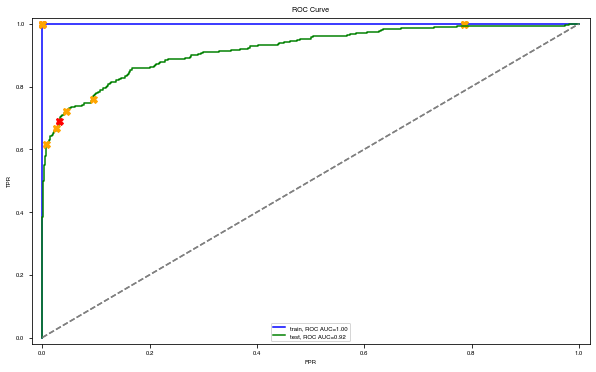

In [77]:
cat_features = X_train.select_dtypes(include=[np.uint8]).columns
cat = CatBoostClassifier(learning_rate=0.2, loss_function='Logloss',
                        random_seed=42)
best_cb_model, best_cb_auc, best_cb_time = build_model(cat, X_train, y_train, 
                                                        X_valid, y_valid,
                                                        hyperparameters={'iterations': range(100, 600, 100)}, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=5, model_str='catboost',
           cat_features=cat_features)

cat.fit(X_train, y_train)
y_pred = cat.predict(X_valid)

print("The confusion matrix is", confusion_matrix(y_valid, y_pred))


display_classification_report(y_valid, y_pred)
result = evaluate_model(cat, X_train, y_train, X_valid, y_valid);

In [78]:
dir(best_cb_model)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_calc_leaf_indexes',
 '_base_drop_unused_features',
 '_base_eval_metrics',
 '_base_predict',
 '_base_shrink',
 '_base_virtual_ensembles_predict',
 '_calc_fstr',
 '_calc_leaf_indexes',
 '_calc_ostr',
 '_check_is_compatible_loss',
 '_convert_to_asymmetric_representation',
 '_deserialize_model',
 '_estimator_type',
 '_eval_metrics',
 '_fit',
 '_get_borders',
 '_get_cat_feature_indices',
 '_get_embedding_feature_indices',
 '_get_float_feature_indices',
 '_get_nan_treatments',
 '_get_params',
 '_get_tags',
 '_get_text_feature_indices',
 '_get_tree_leaf_value

In [79]:
best_cb_model.get_params()

{'iterations': 400,
 'learning_rate': 0.2,
 'loss_function': 'Logloss',
 'random_seed': 42}

In [80]:
model_results_df = pd.DataFrame({'model': ["best_dc_model",
    'LogisticRegression', 
                                           'RandomForestClassifier',
                                           'CatBoostClassifier',
                                           ],
              'best_ROC-AUC': [best_dc_auc, best_lr_auc,  best_rf_auc,  best_cb_auc
                          ],
              'train_time': [best_dc_time, best_lr_time,  best_rf_time,  best_cb_time
                            ],
               'details of final finetuned model using gridsearch and ROC-AUC scorer':  [ DummyClassifier(), best_lr_model, 
                      "RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=500,random_state=42)", 
                               "CatBoostClassifiercatboost(iterations= 400, learning_rate = 0.2, loss_funtion = 'Logloss', random_seed: 42)"]   })

In [81]:
model_results_df.style.set_properties(**{'text-align': 'left'})

,model,best_ROC-AUC,train_time,details of final finetuned model using gridsearch and ROC-AUC scorer
0,best_dc_model,0.500000,0.020000,DummyClassifier()
1,LogisticRegression,0.845459,0.520000,"LogisticRegression(C=1, class_weight='balanced', random_state=42)"
2,RandomForestClassifier,0.884978,133.850000,"RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=500,random_state=42)"
3,CatBoostClassifier,0.919848,21.310000,"CatBoostClassifiercatboost(iterations= 400, learning_rate = 0.2, loss_funtion = 'Logloss', random_seed: 42)"


Observations

- The best model in terms of ROC-AUC is the catboost model.  In addition, its training time is optimal. 
- The precision, recall and F1 of this model are all at 89 compared to 85 for the random forest.

In [82]:
# best features from rf model
pd.DataFrame(best_cb_model.feature_importances_, index=X_train.columns.tolist()).sort_values(0, ascending=False)

,0
total_charges,23.672362
days_of_service,18.254633
monthly_charges,14.752317
month,7.320905
type_Two year,3.696011
internet_service_Fiber optic,3.249970
year,2.976121
day_of_week,2.559471
services,2.127120
dependents,1.975843


Observations

- The order and magnitude of importance of the variables above shifted. The three related, but distinct variables total_charges, days_of_service, monthly_charges climbed to the top of the list with days_of_service slightly decreasing in importance. Type_two_year_contract and internet_service_fiber_optic remained very important. Month and year remained in the top 10 most important features. New feature that became more relevant are day of the week and services.  This is not surprising since we originally normalization of the bar plot above showed their explanatory power.

## Testing the performance of the chosen model

0:	learn: 0.5798484	total: 2.26ms	remaining: 903ms
1:	learn: 0.5240339	total: 5.49ms	remaining: 1.09s
2:	learn: 0.4751599	total: 8.41ms	remaining: 1.11s
3:	learn: 0.4424399	total: 10.7ms	remaining: 1.06s
4:	learn: 0.4232643	total: 14.3ms	remaining: 1.13s
5:	learn: 0.4008260	total: 17ms	remaining: 1.11s
6:	learn: 0.3873857	total: 19.4ms	remaining: 1.09s
7:	learn: 0.3800876	total: 22.8ms	remaining: 1.12s
8:	learn: 0.3747905	total: 25.6ms	remaining: 1.11s
9:	learn: 0.3686450	total: 28.8ms	remaining: 1.12s
10:	learn: 0.3657421	total: 31.3ms	remaining: 1.1s
11:	learn: 0.3590254	total: 33.6ms	remaining: 1.09s
12:	learn: 0.3546356	total: 36.4ms	remaining: 1.08s
13:	learn: 0.3531145	total: 40ms	remaining: 1.1s
14:	learn: 0.3500281	total: 45.6ms	remaining: 1.17s
15:	learn: 0.3469170	total: 52.5ms	remaining: 1.26s
16:	learn: 0.3403561	total: 62ms	remaining: 1.4s
17:	learn: 0.3361766	total: 66ms	remaining: 1.4s
18:	learn: 0.3332431	total: 69.3ms	remaining: 1.39s
19:	learn: 0.3317966	total: 73ms	r

164:	learn: 0.1235385	total: 363ms	remaining: 516ms
165:	learn: 0.1227504	total: 365ms	remaining: 514ms
166:	learn: 0.1221784	total: 368ms	remaining: 513ms
167:	learn: 0.1219806	total: 374ms	remaining: 516ms
168:	learn: 0.1213231	total: 377ms	remaining: 516ms
169:	learn: 0.1206938	total: 379ms	remaining: 513ms
170:	learn: 0.1202721	total: 382ms	remaining: 511ms
171:	learn: 0.1193898	total: 384ms	remaining: 509ms
172:	learn: 0.1191721	total: 386ms	remaining: 507ms
173:	learn: 0.1184594	total: 389ms	remaining: 505ms
174:	learn: 0.1177864	total: 391ms	remaining: 502ms
175:	learn: 0.1176079	total: 393ms	remaining: 500ms
176:	learn: 0.1168706	total: 395ms	remaining: 498ms
177:	learn: 0.1161529	total: 398ms	remaining: 496ms
178:	learn: 0.1156078	total: 400ms	remaining: 494ms
179:	learn: 0.1151808	total: 402ms	remaining: 491ms
180:	learn: 0.1144173	total: 405ms	remaining: 489ms
181:	learn: 0.1139426	total: 408ms	remaining: 488ms
182:	learn: 0.1134804	total: 410ms	remaining: 486ms
183:	learn: 

346:	learn: 0.0548974	total: 729ms	remaining: 111ms
347:	learn: 0.0547268	total: 731ms	remaining: 109ms
348:	learn: 0.0545549	total: 734ms	remaining: 107ms
349:	learn: 0.0544381	total: 736ms	remaining: 105ms
350:	learn: 0.0542748	total: 738ms	remaining: 103ms
351:	learn: 0.0541402	total: 740ms	remaining: 101ms
352:	learn: 0.0539394	total: 743ms	remaining: 98.9ms
353:	learn: 0.0537618	total: 746ms	remaining: 97ms
354:	learn: 0.0535445	total: 750ms	remaining: 95ms
355:	learn: 0.0532029	total: 752ms	remaining: 93ms
356:	learn: 0.0529611	total: 754ms	remaining: 90.9ms
357:	learn: 0.0527074	total: 757ms	remaining: 88.8ms
358:	learn: 0.0526292	total: 759ms	remaining: 86.7ms
359:	learn: 0.0524598	total: 762ms	remaining: 84.6ms
360:	learn: 0.0523479	total: 765ms	remaining: 82.6ms
361:	learn: 0.0521345	total: 767ms	remaining: 80.6ms
362:	learn: 0.0519154	total: 769ms	remaining: 78.4ms
363:	learn: 0.0518042	total: 771ms	remaining: 76.2ms
364:	learn: 0.0517223	total: 773ms	remaining: 74.1ms
365:	

,precision,recall,f1-score,support
0,0.896022,0.971569,0.932267,1020.0000
1,0.904290,0.704370,0.791908,389.0000
accuracy,0.897800,0.897800,0.897800,0.8978
macro avg,0.900156,0.837969,0.862087,1409.0000
weighted avg,0.898305,0.897800,0.893516,1409.0000


          train  test
Accuracy    1.0  0.90
ROC AUC     1.0  0.92


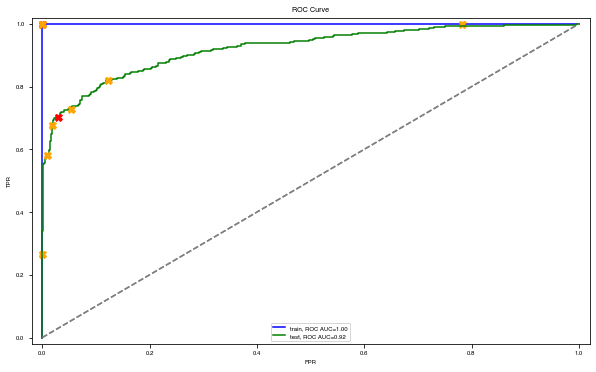

In [83]:
cat = CatBoostClassifier(learning_rate=0.2, loss_function='Logloss', iterations = 400,
                        random_seed=42)

cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

print("The confusion matrix is", confusion_matrix(y_test, y_pred))

display_classification_report(y_test, y_pred)
result = evaluate_model(cat, X_train, y_train, X_test, y_test);

## sanity check

In [84]:
round((0.9198-0.5)/0.9198 * 100, 2)

45.64

Observations

- The performance of the model with the test data remained at 89 indicating no potential overfitting.
- The sanity check indicates that our model of choice performed 45\% better than out dummy classifier.

# Conclusion

In terms of services, most Interconnect churned customers are associated with:

- month-to-month types of contract, 
- paperless billing, 
- electronic checks type of payment,
- fiber optic internet service,
- no online security, 
- no backup support, 
- no device protection,  
- no tech support,
- 1 to 3 total services,

In terms of trends, 

- The last months of the year seem most associated with churning
- Midweek (Wednesday and Thursday) and Saturdays are most associated with churning.

In terms of income,
- The mean monthly charges of those who churned is around 18% higher than those customers who are still active.   
- The bulk of those who churned seems to increase as monthly charges increase.  In may 2019, churning increases gradually to reach a peak in September.
- The mean total charges for those who churned is 40\% less that those who are still active.  Over time, the total charges of active accounts is decreasing.  However, the total charges of those who churned seem t be more volatile
- Churning seems associated with overall lower days of service.  The mean days_of_service for those who churned is half that of those who are still active.  In mid 2018, there seems to be a spike in the days_of_service of those who churned.  Although this surge is attenuated, it does not go back to its pre 2018 levels.  In fact, this surge peaked in January 2019, but has since decreased.
- Churning has been increasing every year and reaches its peak in 2019, but then drops 
 

Based on these observations and the modeling, Interconnect's marketing teams should:

- introduce end of year promotions to entice customers to remain active.
- introduce games or draws to keep customers engaged on Wednesdays and Saturdays.
- gradually remove the month-to-month type of service 
- since those who are going paperless and paying by electronic checks are churning, introduce more environmentally friendly services
- study the monthly charges of those who churned. The variance of those monthly bills need to become smoother.  more specifically target those customers with higher bills.

The team should be heartened that the churning trend is declining and should work on keeping this trend going to stabilize churning over time.